In [822]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

In [823]:
col = ["Service_ID",'Patient_ID','Patient_Number','IMREDEM_CODE',
       'patient_age','Actual_Dr_Name','Place_of_Service_Abbr','Proc_Category_Abbr',
       'Type_of_Service_Abbr','patient_zip_code','patient_sex','Original_Carrier_Name','Patient_City',
       'Patient_State','Diagnosis_Code','Diagnosis_Descr','CoPayment','CoInsurance',
       'Primary_Diagnosis_Code','Procedure_Code','Service_Units','Service_Date_From','Claim_Number', 
       'Original_Billing_Date', 'Date_Paid','Service_Fee','Amount', 'Allowed', 'Deductible',
       'Transaction_Type','Abbreviation' ,'Description', 'Self_Pay_TranCode']


In [824]:
df = pd.read_csv(r'/Users/manjunatha/Downloads/data2.csv', header = None, names = col)
df.shape

(218041, 33)

In [825]:
df["Description"] = df["Description"].apply(lambda x: -999 if str(x).startswith("Self") else x)
self_pay_index = df.loc[df["Description"] == -999].index
df = df.drop(self_pay_index)

In [826]:
list_of_col_drop = ["Self Pay Transfer", "Self Pay Adjustment", "Self Pay Financial Hardship"]
df = df[~df.Description.isin(list_of_col_drop)]
df = df.drop(["IMREDEM_CODE", "Patient_ID"], axis=1)

In [827]:
# Preprocessing
df = df.loc[df["Service_Date_From"] >= "2017-01-01"]
print(df.shape)
df = df.drop_duplicates() #
print(df.shape)
df = df.loc[df["Service_Fee"] > 0]
print(df.shape)
df = df.loc[df["Original_Billing_Date"].notna()]
df = df.loc[df["Date_Paid"].notna()]
index_names = df[(df['Transaction_Type'] == 'T') & (df['Amount']> 0)].index
df.drop(index_names, inplace = True)

(211290, 31)
(188799, 31)
(133006, 31)


In [828]:
# Target variable derviation
df["Original_Billing_Date"] = pd.to_datetime(df["Original_Billing_Date"])
df["Date_Paid"] = pd.to_datetime(df["Date_Paid"])
df["Delay_in_days"] = pd.to_datetime(df["Date_Paid"]) - pd.to_datetime(df["Original_Billing_Date"])
df["Delay_in_days"] = df["Delay_in_days"].apply(lambda x : int(str(x).split(" ")[0]))
df["Payment_portion"] = df["Amount"] / df["Service_Fee"]
df["Decay"] = (1 - (df["Delay_in_days"] / 365))
df["Actual_decay"] = df["Decay"].apply(lambda x : max(0, x))
df["Score"] = df["Actual_decay"] * df["Payment_portion"]

In [829]:
# If the payment is -ve trasaction need to remove those records for that index is taken for last 
#negative transaction and kept and greater index that one
patient_id = df["Patient_Number"].value_counts().keys().tolist()
new_df = pd.DataFrame()
for i in range(len(patient_id)): 
    service_id = df.loc[df["Patient_Number"] == patient_id[i]]
#     new_df = new_df.append(service_id)
    service = service_id.loc[service_id["Score"] < 0].empty

    if service == False:
        index_to_consider_to_drop = service_id.loc[service_id["Score"] < 0].index.tolist()[-1]
        service_id = service_id[service_id.index > index_to_consider_to_drop]
        new_df = new_df.append(service_id)

    else:
        new_df = new_df.append(service_id)
        
# index to drop this will afftect the target score drop the records where payment proportion is 1
# index_to_drop = new_df.loc[new_df["Payment_portion"] == 1.0].index[0]
# new_df = new_df.drop(index_to_drop, axis=0)

# Drop the records where delay in days is coming -ve. because original billing date is coming greater thatn
# date paid column
# new_df = new_df.loc[new_df["Delay_in_days"] >= 0]


# copy the data drame
new_df_copy = new_df

In [830]:
new_df_copy = new_df

In [831]:
new_df_copy.shape

(100364, 36)

In [832]:
# calculationsof weights for the target variable
# def weights(score):
    
#     weight = None
    
#     if score > 0.9 and score <=1.0:
#         weight = 1
        
#     if score > 0.8 and score <= 0.9:
#         weight = 0.9
    
#     if score > 0.7 and score <= 0.8:
#         weight = 0.8
        
#     if score > 0.6 and score <= 0.7:
#         weight = 0.7
        
#     if score > 0.5 and score <= 0.6:
#         weight = 0.6
        
#     if score > 0.4 and score <= 0.5:
#         weight = 0.5
        
#     if score > 0.3 and score <= 0.4:
#         weight = 0.4
        
#     if score > 0.2 and score <= 0.3:
#         weight = 0.3
        
#     if score > 0.1 and score <= 0.2:
#         weight = 0.2
        
#     if score >= 0 and score <= 0.1:
#         weight = 0.1
        
#     return weight
        
# # on the copied data frame weights are applied
# new_df_copy["Weights"] = new_df_copy["Score"].apply(weights)
# # remove the weights where there are null value
# new_df_copy = new_df_copy[~new_df_copy["Weights"].isna()]
# # get the score where score is greated than 0 so that weight_acore will not affect
# new_df_copy = new_df_copy.loc[new_df["Score"] > 0]

In [1197]:
# Create a group data and target variable as mean
x = new_df_copy.groupby(["Service_ID"], as_index=False).agg({
    

    "Patient_Number" : "first",
    'patient_age': "max",
    'Actual_Dr_Name':'first',
    'Place_of_Service_Abbr':'first',
    'Proc_Category_Abbr':'first',
    'Type_of_Service_Abbr':'first',
    'patient_zip_code': "first",
    'patient_sex' : "first",
    'Original_Carrier_Name':"first",
    'Patient_City':"first",
    'Patient_State':"first",
    "Diagnosis_Code" : 'first',
    "Diagnosis_Descr":"first",
    'CoInsurance':"sum", 
    'CoPayment':"sum", 
    "Primary_Diagnosis_Code" : "first",
    "Procedure_Code":"first",
    'Service_Units':"sum",
    'Service_Date_From':"first",
    "Claim_Number" : "first",
    "Original_Billing_Date":"first",
    "Date_Paid":'last',
    "Service_Fee":"max",
    "Amount":"max",
    'Allowed': 'max',
    "Deductible":"max",
    "Transaction_Type":"count",
    "Score": "sum"
})

<AxesSubplot:xlabel='Score', ylabel='Density'>

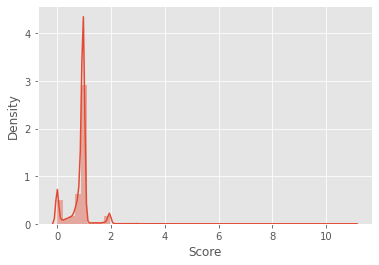

In [1173]:
import seaborn as sns
sns.distplot(x["Score"])

In [1174]:
# Create a weight_Score new dataframe
# weihted_score = new_df_copy.groupby("Service_ID", as_index=False).apply(lambda x: np.average(x['Score'], weights=x['Weights']))
# weihted_score = pd.DataFrame(weihted_score)
# weihted_score["Weighted_Score"] = weihted_score.iloc[:,1]
# weihted_score = weihted_score[["Service_ID", "Weighted_Score"]]
# Combine a dataframe to new dataframe
# new_df_copy = pd.merge(x, weihted_score, on='Service_ID')

In [1198]:
# Aggregate again for the combination
x = x.groupby(["Patient_Number", "Original_Carrier_Name","Primary_Diagnosis_Code","Procedure_Code"], as_index=False).agg({
    
    "Service_ID" : "count",
#     "Patient_Number" : "first",
    'patient_age': "max",
    'Actual_Dr_Name':'first',
    'Place_of_Service_Abbr':'first',
    'Proc_Category_Abbr':'first',
    'Type_of_Service_Abbr':'first',
    'patient_zip_code': "first",
    'patient_sex' : "first",
#     'Original_Carrier_Name':"first",
    'Patient_City':"first",
    'Patient_State':"first",
    "Diagnosis_Code" : 'first',
    "Diagnosis_Descr":"first",
    'CoInsurance':"sum", 
    'CoPayment':"sum", 
#     "Primary_Diagnosis_Code" : "first",
#     "Procedure_Code":"first",
    'Service_Units':"sum",
    'Service_Date_From':"first",
    "Claim_Number" : "first",
    "Original_Billing_Date":"first",
    "Date_Paid":'last',
    "Service_Fee":"max",
    "Amount":"max",
    'Allowed': 'max',
    "Deductible":"max",
    "Transaction_Type":"count",
    "Score": "sum"
})



<AxesSubplot:xlabel='Score', ylabel='Density'>

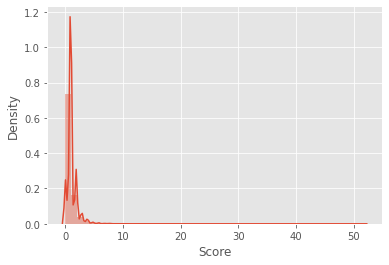

In [1176]:
import seaborn as sns
sns.distplot(x["Score"])

In [921]:
from sklearn.preprocessing import MinMaxScaler

In [1177]:
x = x[x["Score"] < 12]
# x = x.drop_duplicates()

In [1178]:
x.shape

(21024, 29)

In [1179]:
col_names = ['Score']
features = x[col_names]
scaler = MinMaxScaler(feature_range=(0,1))
x[col_names] = scaler.fit_transform(features.values)
x.shape

(21024, 29)

<AxesSubplot:xlabel='Score', ylabel='Density'>

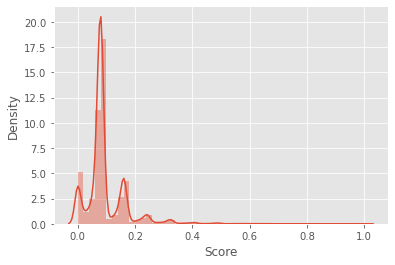

In [1180]:
sns.distplot(x["Score"])

In [1181]:
x.columns

Index(['Patient_Number', 'Original_Carrier_Name', 'Primary_Diagnosis_Code',
       'Procedure_Code', 'Service_ID', 'patient_age', 'Actual_Dr_Name',
       'Place_of_Service_Abbr', 'Proc_Category_Abbr', 'Type_of_Service_Abbr',
       'patient_zip_code', 'patient_sex', 'Patient_City', 'Patient_State',
       'Diagnosis_Code', 'Diagnosis_Descr', 'CoInsurance', 'CoPayment',
       'Service_Units', 'Service_Date_From', 'Claim_Number',
       'Original_Billing_Date', 'Date_Paid', 'Service_Fee', 'Amount',
       'Allowed', 'Deductible', 'Transaction_Type', 'Score'],
      dtype='object')

In [1182]:
x = x.drop("Service_ID", axis=1)
x = x.drop_duplicates()
x["Diagnosis_Code"] = x["Diagnosis_Code"].astype('category')
x["Patient_Number"] = x["Patient_Number"].astype('category')
x["patient_age"] = x["patient_age"].astype('int64')
x["Actual_Dr_Name"] = x["Actual_Dr_Name"].astype('category')
x["Place_of_Service_Abbr"] = x["Place_of_Service_Abbr"].astype('category')
x["Proc_Category_Abbr"] = x["Proc_Category_Abbr"].astype('category')
x["Type_of_Service_Abbr"] = x["Type_of_Service_Abbr"].astype('category')
x["patient_zip_code"] = x["patient_zip_code"].astype('category')
x["patient_sex"] = x["patient_sex"].astype('category')
x["Original_Carrier_Name"] = x["Original_Carrier_Name"].astype('category')
x["Patient_City"] = x["Patient_City"].astype('category')
x["Patient_State"] = x["Patient_State"].astype('category')
x["Diagnosis_Descr"] = x["Diagnosis_Descr"].astype('category')
x["CoInsurance"] = x["CoInsurance"].astype('int64')
x["CoPayment"] = x["CoPayment"].astype('int64')
x["Primary_Diagnosis_Code"] = x["Primary_Diagnosis_Code"].astype('category')
x["Procedure_Code"] = x["Procedure_Code"].astype('category')
x["Service_Units"] = x["Service_Units"].astype("int64")
x["Service_Date_From"] = pd.to_datetime(x["Service_Date_From"])
x["Claim_Number"] = x["Claim_Number"].astype('category')
x["Original_Billing_Date"] = pd.to_datetime(x["Original_Billing_Date"])
x["Date_Paid"] = pd.to_datetime(x["Date_Paid"])
x["Claim_Number"] = x["Claim_Number"].astype('category')

x["Allowed"] = x["Allowed"].fillna(0)
x["Payment_portion_percentage"] = x["Payment_portion_percentage"] = x["Allowed"] / x["Service_Fee"] * 100

x["Score"] = np.round(x["Score"], 2)

In [1183]:
x.shape

(21024, 29)

In [1184]:
x.isna().sum()

Patient_Number                    0
Original_Carrier_Name             0
Primary_Diagnosis_Code            0
Procedure_Code                    0
patient_age                       0
Actual_Dr_Name                    0
Place_of_Service_Abbr             0
Proc_Category_Abbr                0
Type_of_Service_Abbr              0
patient_zip_code                  0
patient_sex                       0
Patient_City                      0
Patient_State                     0
Diagnosis_Code                    0
Diagnosis_Descr                   0
CoInsurance                       0
CoPayment                         0
Service_Units                     0
Service_Date_From                 0
Claim_Number                      0
Original_Billing_Date             0
Date_Paid                         0
Service_Fee                       0
Amount                            0
Allowed                           0
Deductible                    19855
Transaction_Type                  0
Score                       

In [1185]:
# x["Allowed"] = x["Allowed"].fillna(0)
x["Payment_portion_percentage"] = x["Payment_portion_percentage"].fillna(0)
x = x.drop(["Deductible"], axis=1)
from sklearn.impute import SimpleImputer
impute = SimpleImputer(strategy='most_frequent')
x["Original_Carrier_Name"] = impute.fit_transform(x[["Original_Carrier_Name"]])
x.isna().sum()

Patient_Number                0
Original_Carrier_Name         0
Primary_Diagnosis_Code        0
Procedure_Code                0
patient_age                   0
Actual_Dr_Name                0
Place_of_Service_Abbr         0
Proc_Category_Abbr            0
Type_of_Service_Abbr          0
patient_zip_code              0
patient_sex                   0
Patient_City                  0
Patient_State                 0
Diagnosis_Code                0
Diagnosis_Descr               0
CoInsurance                   0
CoPayment                     0
Service_Units                 0
Service_Date_From             0
Claim_Number                  0
Original_Billing_Date         0
Date_Paid                     0
Service_Fee                   0
Amount                        0
Allowed                       0
Transaction_Type              0
Score                         0
Payment_portion_percentage    0
dtype: int64

In [1186]:
import catboost as cb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score, accuracy_score
from sklearn.inspection import permutation_importance
from catboost import CatBoostRegressor

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

import plotly
from plotly.offline import iplot
import plotly.graph_objs as go

import datetime

# Importing libraries for feature selection by varianceThresholdmethod and chi2_contingency
from sklearn.feature_selection import VarianceThreshold
from scipy.stats import chi2_contingency
import statsmodels.api as sm

#Train test split
from sklearn.model_selection import train_test_split
# imputing for missing values
from sklearn.impute import SimpleImputer
# Standerdisation of numeric attributes and dummification of cat features
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

In [1187]:
# x = x.drop("Service_ID", axis=1)
x.drop_duplicates()

,Patient_Number,Original_Carrier_Name,Primary_Diagnosis_Code,Procedure_Code,patient_age,Actual_Dr_Name,Place_of_Service_Abbr,Proc_Category_Abbr,Type_of_Service_Abbr,patient_zip_code,...,Service_Date_From,Claim_Number,Original_Billing_Date,Date_Paid,Service_Fee,Amount,Allowed,Transaction_Type,Score,Payment_portion_percentage
0,61,BCBS of Michigan - Ep,E11.65,36416,41,Allison Pyc,EP Fer,LAB CHEM,LAB,48235,...,2021-07-13,11720510,2021-07-27,2021-12-08,18.0,18.00,0.00,2,0.26,0.000000
1,61,BCBS of Michigan - Ep,E11.65,82962,41,Allison Pyc,EP Fer,LAB CHEM,LAB,48235,...,2021-07-13,11720510,2021-07-27,2021-12-08,6.5,3.28,3.28,2,0.33,50.461538
2,61,BCBS of Michigan - Ep,E11.65,83036,41,Allison Pyc,EP Fer,LAB CHEM,LAB,48235,...,2021-07-13,11720510,2021-07-27,2021-08-04,26.0,14.71,14.71,1,0.16,56.576923
3,85,Medicare Mr,E11.40,82044,77,Barbara J Dalziel,EP Fer,LAB CHEM,LAB,48030,...,2018-05-05,6816720,2018-05-21,2018-06-06,6.5,6.11,6.23,1,0.08,95.846154
4,85,Medicare Mr,E11.40,82570,77,Barbara J Dalziel,EP Fer,LAB CHEM,LAB,48030,...,2018-05-05,6816720,2018-05-21,2018-06-06,9.5,6.26,6.39,1,0.08,67.263158
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21045,723960,BCBS of Michigan,E11.9,82570,32,Christopher Gadoua,EPS10Mil,LAB CHEM,LAB,48390,...,2022-04-18,14294620,2022-04-21,2022-04-27,12.0,8.11,3.89,1,0.08,32.416667
21046,723960,BCBS of Michigan,E11.9,92250,32,Christopher Gadoua,EPS10Mil,MEDICAL,MEDICAL,48390,...,2022-04-18,14294620,2022-04-21,2022-04-27,165.0,105.66,59.34,1,0.07,35.963636
21047,723960,BCBS of Michigan,E11.9,G0506,32,Christopher Gadoua,EPS10Mil,HCPCS_G,OTHER,48390,...,2022-04-18,14294620,2022-04-21,2022-04-27,100.0,0.00,0.00,1,0.00,0.000000
21048,723960,BCBS of Michigan,E11.9,G9001,32,Christopher Gadoua,EPS10Mil,HCPCS_G,OTHER,48390,...,2022-04-18,14298240,2022-04-21,2022-04-27,295.0,182.76,194.43,1,0.08,65.908475


In [1188]:
y = x["Score"]
X = x.drop("Score", axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=123)

In [1189]:
#List of categorical columns
categoricalcolumns = X_train.select_dtypes(include=["category", "object"]).columns.tolist()
print("Names of categorical columns : ", categoricalcolumns)
#Get location of categorical columns
cat_features = [X_train.columns.get_loc(col) for col in categoricalcolumns]
print("Location of categorical columns : ",cat_features)
cat_features = [int(i) for i in cat_features]

Names of categorical columns :  ['Patient_Number', 'Original_Carrier_Name', 'Primary_Diagnosis_Code', 'Procedure_Code', 'Actual_Dr_Name', 'Place_of_Service_Abbr', 'Proc_Category_Abbr', 'Type_of_Service_Abbr', 'patient_zip_code', 'patient_sex', 'Patient_City', 'Patient_State', 'Diagnosis_Code', 'Diagnosis_Descr', 'Claim_Number']
Location of categorical columns :  [0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 19]


In [1190]:
# importing Pool
from catboost import Pool
#Creating pool object for train dataset. we give information of categorical fetures to parameter cat_fetaures
train_data = Pool(data=X_train,
                  label=y_train,
                  cat_features=cat_features
                 )
#Creating pool object for test dataset
test_data = Pool(data=X_test,
                  label=y_test,
                  cat_features=cat_features
                 )

In [1191]:
#build model
cat_model = CatBoostRegressor(loss_function='RMSE')
# Fit model 
cat_model.fit(train_data)

Learning rate set to 0.063952
0:	learn: 0.0726693	total: 54.1ms	remaining: 54.1s
1:	learn: 0.0696534	total: 129ms	remaining: 1m 4s
2:	learn: 0.0667714	total: 245ms	remaining: 1m 21s
3:	learn: 0.0642490	total: 284ms	remaining: 1m 10s
4:	learn: 0.0617976	total: 329ms	remaining: 1m 5s
5:	learn: 0.0595669	total: 359ms	remaining: 59.5s
6:	learn: 0.0575286	total: 389ms	remaining: 55.2s
7:	learn: 0.0556544	total: 425ms	remaining: 52.7s
8:	learn: 0.0538949	total: 462ms	remaining: 50.9s
9:	learn: 0.0522794	total: 504ms	remaining: 49.9s
10:	learn: 0.0508374	total: 543ms	remaining: 48.8s
11:	learn: 0.0495046	total: 582ms	remaining: 47.9s
12:	learn: 0.0482558	total: 616ms	remaining: 46.8s
13:	learn: 0.0471101	total: 656ms	remaining: 46.2s
14:	learn: 0.0461017	total: 710ms	remaining: 46.6s
15:	learn: 0.0452406	total: 755ms	remaining: 46.4s
16:	learn: 0.0443668	total: 786ms	remaining: 45.4s
17:	learn: 0.0435076	total: 817ms	remaining: 44.6s
18:	learn: 0.0427946	total: 844ms	remaining: 43.6s
19:	lear

164:	learn: 0.0298067	total: 6.94s	remaining: 35.1s
165:	learn: 0.0297800	total: 6.97s	remaining: 35s
166:	learn: 0.0297377	total: 7s	remaining: 34.9s
167:	learn: 0.0297282	total: 7.03s	remaining: 34.8s
168:	learn: 0.0297033	total: 7.07s	remaining: 34.8s
169:	learn: 0.0296864	total: 7.1s	remaining: 34.6s
170:	learn: 0.0296541	total: 7.13s	remaining: 34.6s
171:	learn: 0.0296273	total: 7.17s	remaining: 34.5s
172:	learn: 0.0296190	total: 7.21s	remaining: 34.5s
173:	learn: 0.0295890	total: 7.24s	remaining: 34.4s
174:	learn: 0.0295534	total: 7.27s	remaining: 34.3s
175:	learn: 0.0295312	total: 7.3s	remaining: 34.2s
176:	learn: 0.0295119	total: 7.33s	remaining: 34.1s
177:	learn: 0.0295019	total: 7.36s	remaining: 34s
178:	learn: 0.0294863	total: 7.4s	remaining: 33.9s
179:	learn: 0.0294598	total: 7.44s	remaining: 33.9s
180:	learn: 0.0294349	total: 7.47s	remaining: 33.8s
181:	learn: 0.0293532	total: 7.5s	remaining: 33.7s
182:	learn: 0.0293397	total: 7.53s	remaining: 33.6s
183:	learn: 0.0293018	t

326:	learn: 0.0266728	total: 12.6s	remaining: 25.9s
327:	learn: 0.0266466	total: 12.6s	remaining: 25.9s
328:	learn: 0.0266301	total: 12.7s	remaining: 25.8s
329:	learn: 0.0266282	total: 12.7s	remaining: 25.8s
330:	learn: 0.0266120	total: 12.7s	remaining: 25.7s
331:	learn: 0.0266052	total: 12.8s	remaining: 25.7s
332:	learn: 0.0265919	total: 12.8s	remaining: 25.6s
333:	learn: 0.0265841	total: 12.8s	remaining: 25.6s
334:	learn: 0.0265666	total: 12.9s	remaining: 25.5s
335:	learn: 0.0265445	total: 12.9s	remaining: 25.5s
336:	learn: 0.0265323	total: 12.9s	remaining: 25.5s
337:	learn: 0.0265150	total: 13s	remaining: 25.4s
338:	learn: 0.0264945	total: 13s	remaining: 25.4s
339:	learn: 0.0264845	total: 13s	remaining: 25.3s
340:	learn: 0.0264633	total: 13.1s	remaining: 25.3s
341:	learn: 0.0264382	total: 13.1s	remaining: 25.2s
342:	learn: 0.0264142	total: 13.1s	remaining: 25.2s
343:	learn: 0.0264090	total: 13.2s	remaining: 25.1s
344:	learn: 0.0263810	total: 13.2s	remaining: 25.1s
345:	learn: 0.0263

488:	learn: 0.0249290	total: 19.4s	remaining: 20.3s
489:	learn: 0.0249204	total: 19.5s	remaining: 20.3s
490:	learn: 0.0248977	total: 19.5s	remaining: 20.3s
491:	learn: 0.0248893	total: 19.6s	remaining: 20.2s
492:	learn: 0.0248763	total: 19.7s	remaining: 20.2s
493:	learn: 0.0248710	total: 19.7s	remaining: 20.2s
494:	learn: 0.0248649	total: 19.8s	remaining: 20.2s
495:	learn: 0.0248575	total: 19.8s	remaining: 20.1s
496:	learn: 0.0248470	total: 19.8s	remaining: 20.1s
497:	learn: 0.0248395	total: 19.9s	remaining: 20s
498:	learn: 0.0248327	total: 19.9s	remaining: 20s
499:	learn: 0.0248226	total: 19.9s	remaining: 19.9s
500:	learn: 0.0248175	total: 20s	remaining: 19.9s
501:	learn: 0.0247879	total: 20s	remaining: 19.8s
502:	learn: 0.0247857	total: 20.1s	remaining: 19.8s
503:	learn: 0.0247743	total: 20.1s	remaining: 19.8s
504:	learn: 0.0247559	total: 20.2s	remaining: 19.8s
505:	learn: 0.0247552	total: 20.2s	remaining: 19.7s
506:	learn: 0.0247469	total: 20.3s	remaining: 19.7s
507:	learn: 0.024733

648:	learn: 0.0235531	total: 27s	remaining: 14.6s
649:	learn: 0.0235500	total: 27s	remaining: 14.6s
650:	learn: 0.0235483	total: 27.1s	remaining: 14.5s
651:	learn: 0.0235425	total: 27.1s	remaining: 14.5s
652:	learn: 0.0235332	total: 27.1s	remaining: 14.4s
653:	learn: 0.0235298	total: 27.2s	remaining: 14.4s
654:	learn: 0.0235211	total: 27.2s	remaining: 14.3s
655:	learn: 0.0235206	total: 27.3s	remaining: 14.3s
656:	learn: 0.0235174	total: 27.3s	remaining: 14.2s
657:	learn: 0.0235163	total: 27.3s	remaining: 14.2s
658:	learn: 0.0235114	total: 27.4s	remaining: 14.2s
659:	learn: 0.0235048	total: 27.4s	remaining: 14.1s
660:	learn: 0.0234930	total: 27.5s	remaining: 14.1s
661:	learn: 0.0234897	total: 27.5s	remaining: 14s
662:	learn: 0.0234877	total: 27.5s	remaining: 14s
663:	learn: 0.0234779	total: 27.6s	remaining: 13.9s
664:	learn: 0.0234673	total: 27.6s	remaining: 13.9s
665:	learn: 0.0234563	total: 27.6s	remaining: 13.9s
666:	learn: 0.0234523	total: 27.7s	remaining: 13.8s
667:	learn: 0.023449

807:	learn: 0.0224398	total: 33.1s	remaining: 7.86s
808:	learn: 0.0224254	total: 33.1s	remaining: 7.82s
809:	learn: 0.0224248	total: 33.1s	remaining: 7.77s
810:	learn: 0.0224121	total: 33.2s	remaining: 7.73s
811:	learn: 0.0224095	total: 33.2s	remaining: 7.69s
812:	learn: 0.0224038	total: 33.2s	remaining: 7.64s
813:	learn: 0.0223952	total: 33.3s	remaining: 7.6s
814:	learn: 0.0223915	total: 33.3s	remaining: 7.56s
815:	learn: 0.0223839	total: 33.4s	remaining: 7.52s
816:	learn: 0.0223774	total: 33.4s	remaining: 7.48s
817:	learn: 0.0223572	total: 33.4s	remaining: 7.44s
818:	learn: 0.0223521	total: 33.5s	remaining: 7.4s
819:	learn: 0.0223370	total: 33.5s	remaining: 7.36s
820:	learn: 0.0223288	total: 33.5s	remaining: 7.31s
821:	learn: 0.0223181	total: 33.6s	remaining: 7.27s
822:	learn: 0.0223105	total: 33.6s	remaining: 7.23s
823:	learn: 0.0223088	total: 33.6s	remaining: 7.18s
824:	learn: 0.0223053	total: 33.7s	remaining: 7.14s
825:	learn: 0.0223026	total: 33.7s	remaining: 7.1s
826:	learn: 0.0

969:	learn: 0.0215009	total: 38.9s	remaining: 1.2s
970:	learn: 0.0214965	total: 38.9s	remaining: 1.16s
971:	learn: 0.0214878	total: 39s	remaining: 1.12s
972:	learn: 0.0214850	total: 39s	remaining: 1.08s
973:	learn: 0.0214841	total: 39s	remaining: 1.04s
974:	learn: 0.0214797	total: 39.1s	remaining: 1s
975:	learn: 0.0214759	total: 39.1s	remaining: 962ms
976:	learn: 0.0214726	total: 39.2s	remaining: 922ms
977:	learn: 0.0214724	total: 39.2s	remaining: 881ms
978:	learn: 0.0214643	total: 39.2s	remaining: 841ms
979:	learn: 0.0214599	total: 39.2s	remaining: 801ms
980:	learn: 0.0214431	total: 39.3s	remaining: 761ms
981:	learn: 0.0214422	total: 39.3s	remaining: 721ms
982:	learn: 0.0214342	total: 39.4s	remaining: 681ms
983:	learn: 0.0214280	total: 39.4s	remaining: 641ms
984:	learn: 0.0214234	total: 39.4s	remaining: 600ms
985:	learn: 0.0214165	total: 39.5s	remaining: 560ms
986:	learn: 0.0214101	total: 39.5s	remaining: 520ms
987:	learn: 0.0214065	total: 39.5s	remaining: 480ms
988:	learn: 0.0214045	

In [1192]:
y_train_pred = cat_model.predict(X_train)
y_test_pred = cat_model.predict(X_test)
def model_score(y_train, y_train_pred, y_test, y_test_pred):
    print("Training performance")
    mean_sq_error = mean_squared_error(y_train, y_train_pred)
    print("Mean squared error {:.2f}".format(mean_sq_error))
    rmse = (np.sqrt(mean_squared_error(y_train, y_train_pred)))
    print('RMSE: {:.2f}'.format(rmse))
    r2_score_ = r2_score(y_train,y_train_pred)
    print('r2_score is : {:.2f}'.format(r2_score_))
#     mean_absolute_error_ = mean_absolute_error(y_train, y_train_pred)
#     print('mean_absolute_error is : {:.2f}'.format(mean_absolute_error_))
# #     mean_absolute_percentage_error_ = mean_absolute_percentage_error(y_train, y_train_pred)
#     adjusted_r_square = r2AndAdjustedr2(y_train, y_train_pred)
#     print("Adjusted r square is : {:.2f}".format(adjusted_r_square))
    
    print("************************")
    print("Testing performance")
    mean_sq_error = mean_squared_error(y_test, y_test_pred)
    print("Mean squared error {:.2f}".format(mean_sq_error))
    rmse = (np.sqrt(mean_squared_error(y_test, y_test_pred)))
    print('RMSE: {:.2f}'.format(rmse))
    r2_score_ = r2_score(y_test,y_test_pred)
    print('r2_score is : {:.2f}'.format(r2_score_))
#     mean_absolute_error_ = mean_absolute_error(y_test, y_test_pred)
#     print('mean_absolute_error is : {:.2f}'.format(mean_absolute_error_))
# #     mean_absolute_percentage_error_ = mean_absolute_percentage_error(y_test, y_test_pred)
#     adjusted_r_square = r2AndAdjustedr2(y_test, y_test_pred)
#     print("Adjusted r square is : {:.2f}".format(adjusted_r_square))
    
    
    return


print(model_score(y_train, y_train_pred, y_test, y_test_pred))

Training performance
Mean squared error 0.00
RMSE: 0.02
r2_score is : 0.92
************************
Testing performance
Mean squared error 0.00
RMSE: 0.03
r2_score is : 0.87
None


Text(0.5, 0, 'CatBoost Feature Importance')

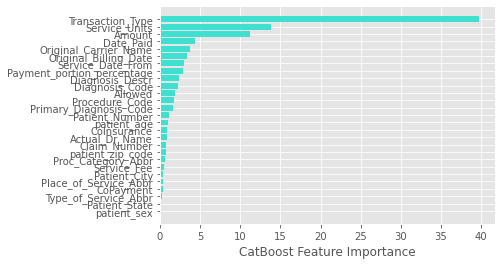

In [1193]:
sorted_feature_importance = cat_model.feature_importances_.argsort()
plt.barh(X_train.columns[sorted_feature_importance], 
        cat_model.feature_importances_[sorted_feature_importance], 
        color='turquoise')
plt.xlabel("CatBoost Feature Importance")

In [1194]:
y_train = y_train.reset_index(drop=True)
y_train_pred = pd.Series(y_train_pred, name="Predicted_train_score").reset_index(drop = True)
prediction_on_train_data = pd.concat([y_train, y_train_pred], axis=1)
y_test = y_test.reset_index(drop=True)
y_test_pred = pd.Series(y_test_pred, name="Predicted_test_score").reset_index(drop = True)
prediction_on_test_data = pd.concat([y_test, y_test_pred], axis=1)

import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

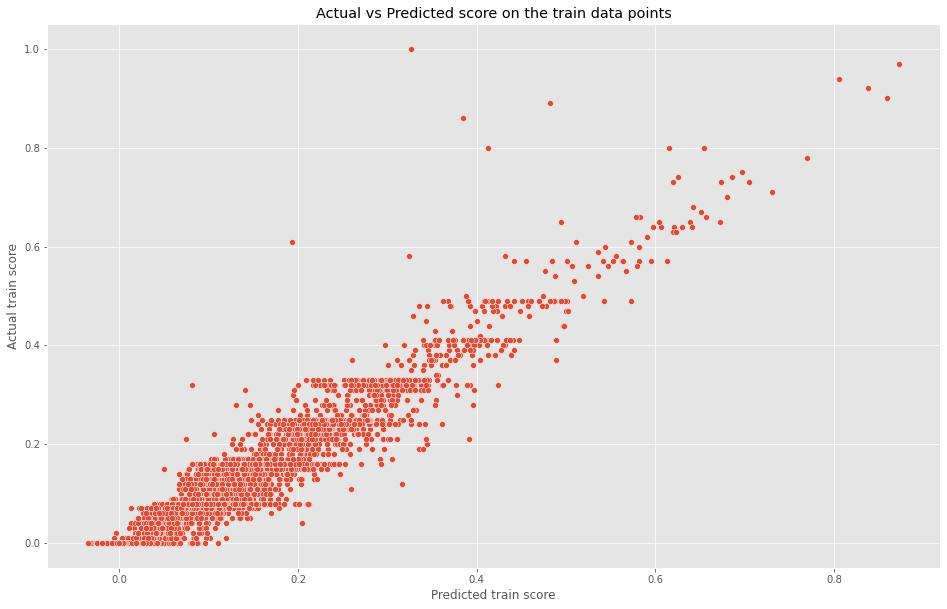

In [1195]:
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
import matplotlib.style as style 
style.use("ggplot")
plt.figure(figsize=(16,10))
sns.scatterplot(prediction_on_train_data["Predicted_train_score"],prediction_on_train_data["Score"])
plt.xlabel("Predicted train score")
plt.ylabel("Actual train score")
plt.title("Actual vs Predicted score on the train data points")


print()
plt.show()

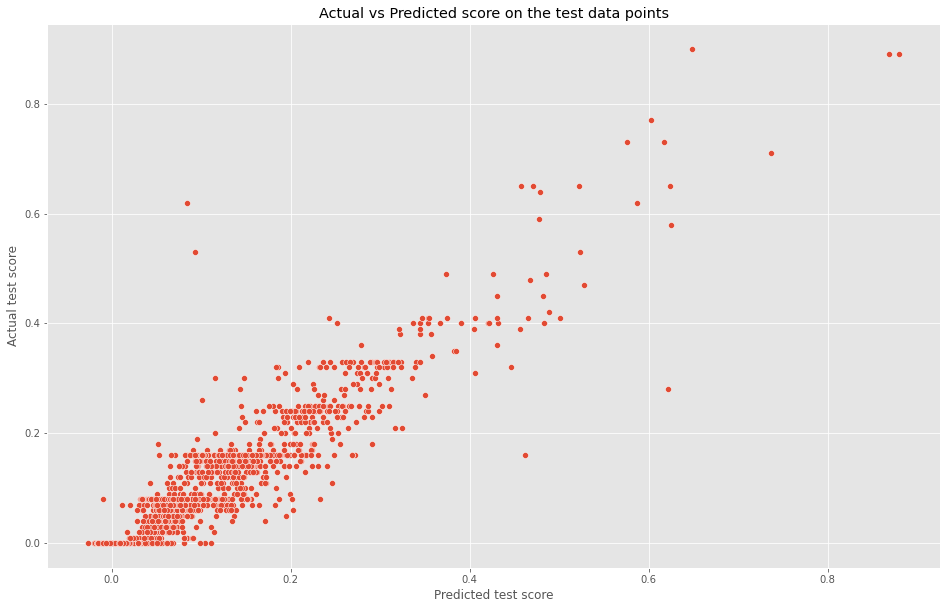

In [1196]:
import matplotlib.style as style 
style.use("ggplot")
plt.figure(figsize=(16,10))
sns.scatterplot(prediction_on_test_data["Predicted_test_score"], prediction_on_test_data["Score"])
plt.xlabel("Predicted test score")
plt.ylabel("Actual test score")
plt.title("Actual vs Predicted score on the test data points")

print()
plt.show()

## Modelling part


In [581]:
import seaborn as sns
# sns.boxplot(x["Score"])
x[x["Score"] > 15]

,Patient_Number,Original_Carrier_Name,Primary_Diagnosis_Code,Procedure_Code,Service_ID,patient_age,Actual_Dr_Name,Place_of_Service_Abbr,Proc_Category_Abbr,Type_of_Service_Abbr,...,Service_Date_From,Claim_Number,Original_Billing_Date,Date_Paid,Service_Fee,Amount,Allowed,Deductible,Transaction_Type,Score
1618,7866,Blue Cross Complete (Medicaid),E11.9,99213,17,60,Exercise Physiology,EP Fer,EVALMGMT,MEDICAL,...,2021-02-04,10407110,2021-02-19,2022-04-27,170.0,94.77,76.90,NaN,17,16.684932
4220,69547,Total Healthcare,E11.9,99213,53,63,Exercise Physiology,EP Fer,EVALMGMT,MEDICAL,...,2021-02-11,10447120,2021-04-23,2021-12-23,170.0,137.50,107.10,NaN,53,51.725919
6704,270420,Blue Cross Complete (Medicaid),E11.22,99214,13,58,Joshua A Ruedisueli,EPIC D,EVALMGMT,MEDICAL,...,2017-04-17,5553370,2017-04-19,2022-04-27,220.0,125.72,109.11,NaN,13,24.235616
6852,272480,Meridian Health Plan Of MI(MEDICAID),E11.9,99213,17,56,Exercise Physiology,EPDLiv,EVALMGMT,MEDICAL,...,2021-10-28,12557480,2021-11-12,2022-03-28,170.0,170.00,70.17,NaN,17,16.679452
8386,316360,Humana Medicare,E11.9,99213,16,76,Exercise Physiology,EPDLiv,EVALMGMT,MEDICAL,...,2020-12-18,10730310,2021-03-29,2022-02-25,170.0,94.51,94.51,NaN,16,15.484932
8743,329480,Hap Senior Plus,E11.51,99213,19,68,Exercise Physiology,EPDLiv,EVALMGMT,MEDICAL,...,2022-01-10,13144050,2022-01-12,2022-04-19,170.0,94.51,94.51,NaN,19,18.597463
9339,357230,Meridian Healthcare of Mi,E11.42,99214,8,53,Mary Girjis,EPS10Mil,EVALMGMT,MEDICAL,...,2021-07-02,11630800,2021-07-10,2022-03-28,220.0,145.71,99.19,NaN,8,15.720548
11241,410050,BCBS of Michigan - Ep,E11.9,99213,18,40,Exercise Physiology,EP Fer,EVALMGMT,MEDICAL,...,2021-02-19,10493040,2021-05-04,2022-05-22,170.0,91.99,109.51,NaN,18,16.214499
11616,422580,Molina Medicaid,E11.9,99213,34,59,Dennis Kain,EPDLiv,EVALMGMT,MEDICAL,...,2021-01-13,10279650,2021-04-19,2022-04-16,170.0,93.10,77.19,NaN,34,33.408219
11876,432360,Aetna Medicare,E11.9,99213,18,73,Exercise Physiology,EP Fer,EVALMGMT,MEDICAL,...,2022-01-18,13381490,2022-02-04,2022-04-20,170.0,94.07,94.07,NaN,18,17.001911


In [945]:
x_copy = x[x["Score"] <= 15]

In [946]:
x_copy["Score"].describe()

count    21033.000000
mean         1.157200
std          0.945579
min          0.000000
25%          0.863014
50%          0.967123
75%          0.989041
max         14.687671
Name: Score, dtype: float64

In [947]:
# Clip the target variable
# x["Score"] = x["Score"].clip(np.quantile(x["Score"], 0.01), np.quantile(x["Score"], 0.99))

In [948]:
col_names = ['Score']
features = x_copy[col_names]
scaler = MinMaxScaler(feature_range=(0,1))
x_copy[col_names] = scaler.fit_transform(features.values)
x.shape

(21050, 29)

In [949]:
x_copy = x_copy.drop_duplicates()
x_copy["Diagnosis_Code"] = x_copy["Diagnosis_Code"].astype('category')
x_copy["Patient_Number"] = x_copy["Patient_Number"].astype('category')
x_copy["patient_age"] = x_copy["patient_age"].astype('int64')
x_copy["Actual_Dr_Name"] = x_copy["Actual_Dr_Name"].astype('category')
x_copy["Place_of_Service_Abbr"] = x_copy["Place_of_Service_Abbr"].astype('category')
x_copy["Proc_Category_Abbr"] = x_copy["Proc_Category_Abbr"].astype('category')
x_copy["Type_of_Service_Abbr"] = x_copy["Type_of_Service_Abbr"].astype('category')
x_copy["patient_zip_code"] = x_copy["patient_zip_code"].astype('category')
x_copy["patient_sex"] = x_copy["patient_sex"].astype('category')
x_copy["Original_Carrier_Name"] = x_copy["Original_Carrier_Name"].astype('category')
x_copy["Patient_City"] = x_copy["Patient_City"].astype('category')
x_copy["Patient_State"] = x["Patient_State"].astype('category')
x_copy["Diagnosis_Descr"] = x_copy["Diagnosis_Descr"].astype('category')
x_copy["CoInsurance"] = x_copy["CoInsurance"].astype('int64')
x_copy["CoPayment"] = x_copy["CoPayment"].astype('int64')
x_copy["Primary_Diagnosis_Code"] = x_copy["Primary_Diagnosis_Code"].astype('category')
x_copy["Procedure_Code"] = x_copy["Procedure_Code"].astype('category')
x_copy["Service_Units"] = x_copy["Service_Units"].astype("int64")
x_copy["Service_Date_From"] = pd.to_datetime(x_copy["Service_Date_From"])
x_copy["Claim_Number"] = x_copy["Claim_Number"].astype('category')
x_copy["Original_Billing_Date"] = pd.to_datetime(x_copy["Original_Billing_Date"])
x_copy["Date_Paid"] = pd.to_datetime(x_copy["Date_Paid"])
x_copy["Claim_Number"] = x_copy["Claim_Number"].astype('category')

x_copy["Allowed"] = x_copy["Allowed"].fillna(0)
x_copy["Payment_portion_percentage"] = x_copy["Payment_portion_percentage"] = x_copy["Allowed"] / x_copy["Service_Fee"] * 100

x_copy["Score"] = np.round(x_copy["Score"], 2)

In [950]:
x_copy.isna().sum()

Patient_Number                    0
Original_Carrier_Name             0
Primary_Diagnosis_Code            0
Procedure_Code                    0
Service_ID                        0
patient_age                       0
Actual_Dr_Name                    0
Place_of_Service_Abbr             0
Proc_Category_Abbr                0
Type_of_Service_Abbr              0
patient_zip_code                  0
patient_sex                       0
Patient_City                      0
Patient_State                     0
Diagnosis_Code                    0
Diagnosis_Descr                   0
CoInsurance                       0
CoPayment                         0
Service_Units                     0
Service_Date_From                 0
Claim_Number                      0
Original_Billing_Date             0
Date_Paid                         0
Service_Fee                       0
Amount                            0
Allowed                           0
Deductible                    19863
Transaction_Type            

In [951]:
# x["Allowed"] = x["Allowed"].fillna(0)
x_copy["Payment_portion_percentage"] = x_copy["Payment_portion_percentage"].fillna(0)
x_copy = x_copy.drop(["Deductible"], axis=1)
from sklearn.impute import SimpleImputer
impute = SimpleImputer(strategy='most_frequent')
x_copy["Original_Carrier_Name"] = impute.fit_transform(x_copy[["Original_Carrier_Name"]])
x_copy.isna().sum()

Patient_Number                0
Original_Carrier_Name         0
Primary_Diagnosis_Code        0
Procedure_Code                0
Service_ID                    0
patient_age                   0
Actual_Dr_Name                0
Place_of_Service_Abbr         0
Proc_Category_Abbr            0
Type_of_Service_Abbr          0
patient_zip_code              0
patient_sex                   0
Patient_City                  0
Patient_State                 0
Diagnosis_Code                0
Diagnosis_Descr               0
CoInsurance                   0
CoPayment                     0
Service_Units                 0
Service_Date_From             0
Claim_Number                  0
Original_Billing_Date         0
Date_Paid                     0
Service_Fee                   0
Amount                        0
Allowed                       0
Transaction_Type              0
Score                         0
Payment_portion_percentage    0
dtype: int64

In [576]:
x_copy = x_copy.drop("Service_ID", axis=1)
y = x_copy["Score"]
X = x_copy.drop("Score", axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=123)
#List of categorical columns
categoricalcolumns = X_train.select_dtypes(include=["category", "object"]).columns.tolist()
print("Names of categorical columns : ", categoricalcolumns)
#Get location of categorical columns
cat_features = [X_train.columns.get_loc(col) for col in categoricalcolumns]
print("Location of categorical columns : ",cat_features)
cat_features = [int(i) for i in cat_features]

# importing Pool
from catboost import Pool
#Creating pool object for train dataset. we give information of categorical fetures to parameter cat_fetaures
train_data = Pool(data=X_train,
                  label=y_train,
                  cat_features=cat_features
                 )
#Creating pool object for test dataset
test_data = Pool(data=X_test,
                  label=y_test,
                  cat_features=cat_features
                 )

#build model
cat_model = CatBoostRegressor(loss_function='RMSE')
# Fit model 
cat_model.fit(train_data)

y_train_pred = cat_model.predict(X_train)
y_test_pred = cat_model.predict(X_test)

print(model_score(y_train, y_train_pred, y_test, y_test_pred))

Names of categorical columns :  ['Patient_Number', 'Original_Carrier_Name', 'Primary_Diagnosis_Code', 'Procedure_Code', 'Actual_Dr_Name', 'Place_of_Service_Abbr', 'Proc_Category_Abbr', 'Type_of_Service_Abbr', 'patient_zip_code', 'patient_sex', 'Patient_City', 'Patient_State', 'Diagnosis_Code', 'Diagnosis_Descr', 'Claim_Number']
Location of categorical columns :  [0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 19]
Learning rate set to 0.063956
0:	learn: 0.0623803	total: 126ms	remaining: 2m 5s
1:	learn: 0.0597580	total: 187ms	remaining: 1m 33s
2:	learn: 0.0573174	total: 229ms	remaining: 1m 16s
3:	learn: 0.0550417	total: 274ms	remaining: 1m 8s
4:	learn: 0.0529629	total: 314ms	remaining: 1m 2s
5:	learn: 0.0510336	total: 345ms	remaining: 57.2s
6:	learn: 0.0492764	total: 379ms	remaining: 53.8s
7:	learn: 0.0476939	total: 429ms	remaining: 53.1s
8:	learn: 0.0461796	total: 473ms	remaining: 52.1s
9:	learn: 0.0448326	total: 510ms	remaining: 50.5s
10:	learn: 0.0435676	total: 546ms	remaining: 49.1s


154:	learn: 0.0261023	total: 6.52s	remaining: 35.5s
155:	learn: 0.0260805	total: 6.56s	remaining: 35.5s
156:	learn: 0.0260675	total: 6.59s	remaining: 35.4s
157:	learn: 0.0260511	total: 6.63s	remaining: 35.3s
158:	learn: 0.0260087	total: 6.66s	remaining: 35.2s
159:	learn: 0.0259795	total: 6.69s	remaining: 35.1s
160:	learn: 0.0259491	total: 6.73s	remaining: 35.1s
161:	learn: 0.0259140	total: 6.77s	remaining: 35s
162:	learn: 0.0259053	total: 6.81s	remaining: 35s
163:	learn: 0.0258957	total: 6.84s	remaining: 34.9s
164:	learn: 0.0258698	total: 6.87s	remaining: 34.8s
165:	learn: 0.0258560	total: 6.9s	remaining: 34.7s
166:	learn: 0.0258385	total: 6.94s	remaining: 34.6s
167:	learn: 0.0257810	total: 6.98s	remaining: 34.6s
168:	learn: 0.0257661	total: 7.02s	remaining: 34.5s
169:	learn: 0.0257603	total: 7.06s	remaining: 34.5s
170:	learn: 0.0257349	total: 7.1s	remaining: 34.4s
171:	learn: 0.0257069	total: 7.13s	remaining: 34.3s
172:	learn: 0.0256841	total: 7.17s	remaining: 34.3s
173:	learn: 0.0256

318:	learn: 0.0230073	total: 12.7s	remaining: 27.1s
319:	learn: 0.0229997	total: 12.7s	remaining: 27s
320:	learn: 0.0229920	total: 12.7s	remaining: 27s
321:	learn: 0.0229852	total: 12.8s	remaining: 26.9s
322:	learn: 0.0229686	total: 12.8s	remaining: 26.9s
323:	learn: 0.0229636	total: 12.8s	remaining: 26.8s
324:	learn: 0.0229610	total: 12.9s	remaining: 26.8s
325:	learn: 0.0229583	total: 12.9s	remaining: 26.8s
326:	learn: 0.0229361	total: 13s	remaining: 26.7s
327:	learn: 0.0229261	total: 13s	remaining: 26.7s
328:	learn: 0.0229087	total: 13.1s	remaining: 26.7s
329:	learn: 0.0229085	total: 13.1s	remaining: 26.6s
330:	learn: 0.0228999	total: 13.2s	remaining: 26.6s
331:	learn: 0.0228858	total: 13.2s	remaining: 26.6s
332:	learn: 0.0228672	total: 13.2s	remaining: 26.5s
333:	learn: 0.0228592	total: 13.3s	remaining: 26.5s
334:	learn: 0.0228492	total: 13.3s	remaining: 26.4s
335:	learn: 0.0228354	total: 13.3s	remaining: 26.4s
336:	learn: 0.0228333	total: 13.4s	remaining: 26.3s
337:	learn: 0.022822

480:	learn: 0.0212929	total: 19.4s	remaining: 21s
481:	learn: 0.0212868	total: 19.5s	remaining: 20.9s
482:	learn: 0.0212822	total: 19.5s	remaining: 20.9s
483:	learn: 0.0212710	total: 19.5s	remaining: 20.8s
484:	learn: 0.0212596	total: 19.6s	remaining: 20.8s
485:	learn: 0.0212576	total: 19.6s	remaining: 20.7s
486:	learn: 0.0212550	total: 19.6s	remaining: 20.7s
487:	learn: 0.0212497	total: 19.7s	remaining: 20.7s
488:	learn: 0.0212462	total: 19.7s	remaining: 20.6s
489:	learn: 0.0212354	total: 19.8s	remaining: 20.6s
490:	learn: 0.0212291	total: 19.8s	remaining: 20.5s
491:	learn: 0.0212222	total: 19.8s	remaining: 20.5s
492:	learn: 0.0212162	total: 19.9s	remaining: 20.4s
493:	learn: 0.0212033	total: 19.9s	remaining: 20.4s
494:	learn: 0.0212011	total: 20s	remaining: 20.4s
495:	learn: 0.0211967	total: 20s	remaining: 20.3s
496:	learn: 0.0211871	total: 20s	remaining: 20.3s
497:	learn: 0.0211826	total: 20.1s	remaining: 20.2s
498:	learn: 0.0211724	total: 20.1s	remaining: 20.2s
499:	learn: 0.021158

643:	learn: 0.0202186	total: 26.2s	remaining: 14.5s
644:	learn: 0.0202134	total: 26.3s	remaining: 14.5s
645:	learn: 0.0202107	total: 26.3s	remaining: 14.4s
646:	learn: 0.0202064	total: 26.3s	remaining: 14.4s
647:	learn: 0.0202040	total: 26.4s	remaining: 14.3s
648:	learn: 0.0201988	total: 26.4s	remaining: 14.3s
649:	learn: 0.0201852	total: 26.5s	remaining: 14.3s
650:	learn: 0.0201844	total: 26.5s	remaining: 14.2s
651:	learn: 0.0201838	total: 26.6s	remaining: 14.2s
652:	learn: 0.0201757	total: 26.6s	remaining: 14.1s
653:	learn: 0.0201676	total: 26.6s	remaining: 14.1s
654:	learn: 0.0201638	total: 26.7s	remaining: 14s
655:	learn: 0.0201516	total: 26.7s	remaining: 14s
656:	learn: 0.0201450	total: 26.8s	remaining: 14s
657:	learn: 0.0201311	total: 26.8s	remaining: 13.9s
658:	learn: 0.0201294	total: 26.8s	remaining: 13.9s
659:	learn: 0.0201253	total: 26.9s	remaining: 13.8s
660:	learn: 0.0201121	total: 26.9s	remaining: 13.8s
661:	learn: 0.0201056	total: 26.9s	remaining: 13.8s
662:	learn: 0.0200

806:	learn: 0.0193522	total: 33.5s	remaining: 8.01s
807:	learn: 0.0193482	total: 33.5s	remaining: 7.97s
808:	learn: 0.0193477	total: 33.6s	remaining: 7.93s
809:	learn: 0.0193334	total: 33.6s	remaining: 7.88s
810:	learn: 0.0193323	total: 33.7s	remaining: 7.85s
811:	learn: 0.0193293	total: 33.8s	remaining: 7.83s
812:	learn: 0.0193049	total: 33.9s	remaining: 7.79s
813:	learn: 0.0193019	total: 33.9s	remaining: 7.75s
814:	learn: 0.0193009	total: 34s	remaining: 7.71s
815:	learn: 0.0192969	total: 34.1s	remaining: 7.68s
816:	learn: 0.0192967	total: 34.1s	remaining: 7.64s
817:	learn: 0.0192887	total: 34.2s	remaining: 7.6s
818:	learn: 0.0192806	total: 34.2s	remaining: 7.56s
819:	learn: 0.0192787	total: 34.3s	remaining: 7.52s
820:	learn: 0.0192777	total: 34.3s	remaining: 7.49s
821:	learn: 0.0192751	total: 34.4s	remaining: 7.45s
822:	learn: 0.0192740	total: 34.4s	remaining: 7.41s
823:	learn: 0.0192668	total: 34.5s	remaining: 7.38s
824:	learn: 0.0192541	total: 34.6s	remaining: 7.34s
825:	learn: 0.0

967:	learn: 0.0184084	total: 41.2s	remaining: 1.36s
968:	learn: 0.0184078	total: 41.3s	remaining: 1.32s
969:	learn: 0.0183977	total: 41.3s	remaining: 1.28s
970:	learn: 0.0183932	total: 41.3s	remaining: 1.23s
971:	learn: 0.0183912	total: 41.4s	remaining: 1.19s
972:	learn: 0.0183846	total: 41.4s	remaining: 1.15s
973:	learn: 0.0183777	total: 41.4s	remaining: 1.11s
974:	learn: 0.0183764	total: 41.5s	remaining: 1.06s
975:	learn: 0.0183739	total: 41.5s	remaining: 1.02s
976:	learn: 0.0183705	total: 41.6s	remaining: 978ms
977:	learn: 0.0183691	total: 41.6s	remaining: 936ms
978:	learn: 0.0183646	total: 41.6s	remaining: 893ms
979:	learn: 0.0183629	total: 41.7s	remaining: 851ms
980:	learn: 0.0183601	total: 41.7s	remaining: 808ms
981:	learn: 0.0183546	total: 41.8s	remaining: 766ms
982:	learn: 0.0183525	total: 41.8s	remaining: 723ms
983:	learn: 0.0183498	total: 41.8s	remaining: 680ms
984:	learn: 0.0183485	total: 41.9s	remaining: 638ms
985:	learn: 0.0183476	total: 41.9s	remaining: 595ms
986:	learn: 

Text(0.5, 0, 'CatBoost Feature Importance')

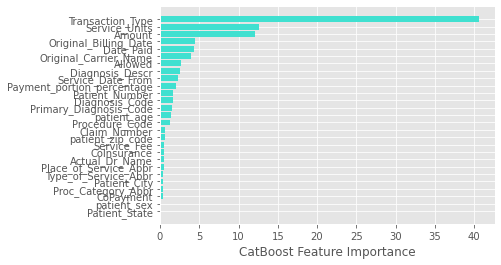

In [577]:
sorted_feature_importance = cat_model.feature_importances_.argsort()
plt.barh(X_train.columns[sorted_feature_importance], 
        cat_model.feature_importances_[sorted_feature_importance], 
        color='turquoise')
plt.xlabel("CatBoost Feature Importance")

In [578]:
y_train = y_train.reset_index(drop=True)
y_train_pred = pd.Series(y_train_pred, name="Predicted_train_score").reset_index(drop = True)
prediction_on_train_data = pd.concat([y_train, y_train_pred], axis=1)
y_test = y_test.reset_index(drop=True)
y_test_pred = pd.Series(y_test_pred, name="Predicted_test_score").reset_index(drop = True)
prediction_on_test_data = pd.concat([y_test, y_test_pred], axis=1)

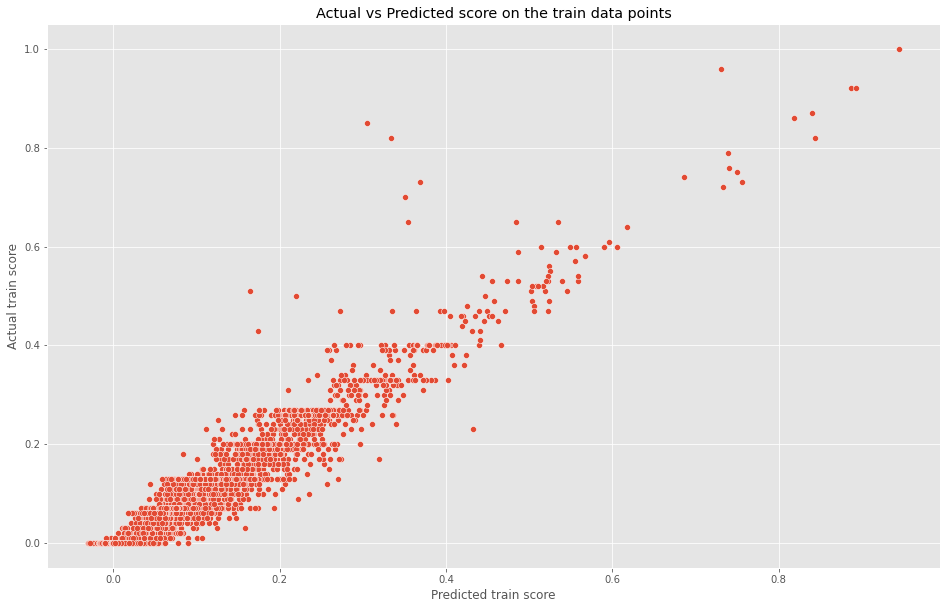

In [579]:
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
import matplotlib.style as style 
style.use("ggplot")
plt.figure(figsize=(16,10))
sns.scatterplot(prediction_on_train_data["Predicted_train_score"],prediction_on_train_data["Score"])
plt.xlabel("Predicted train score")
plt.ylabel("Actual train score")
plt.title("Actual vs Predicted score on the train data points")


print()
plt.show()

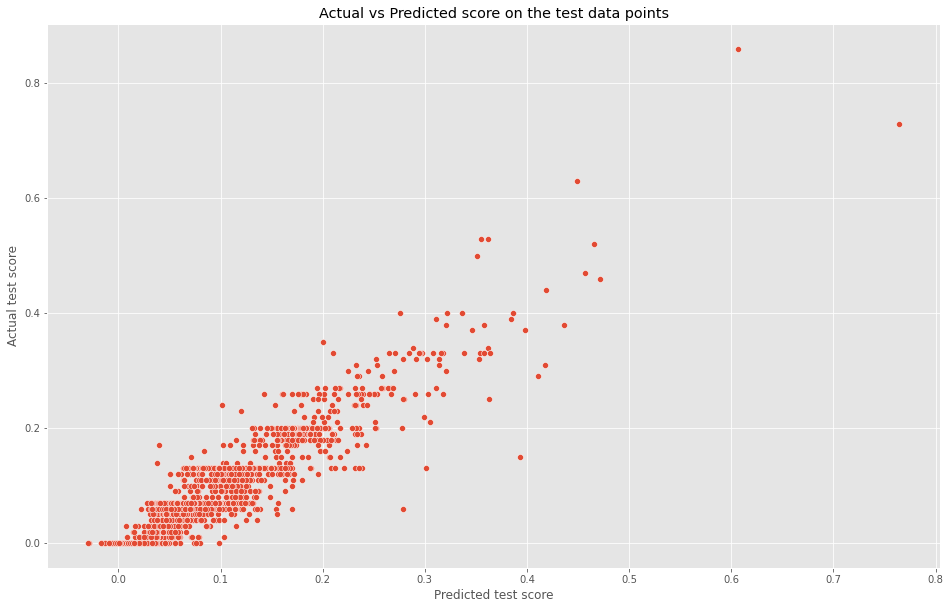

In [580]:
import matplotlib.style as style 
style.use("ggplot")
plt.figure(figsize=(16,10))
sns.scatterplot(prediction_on_test_data["Predicted_test_score"], prediction_on_test_data["Score"])
plt.xlabel("Predicted test score")
plt.ylabel("Actual test score")
plt.title("Actual vs Predicted score on the test data points")

print()
plt.show()

# Modelling part

In [1199]:
x

,Patient_Number,Original_Carrier_Name,Primary_Diagnosis_Code,Procedure_Code,Service_ID,patient_age,Actual_Dr_Name,Place_of_Service_Abbr,Proc_Category_Abbr,Type_of_Service_Abbr,...,Service_Date_From,Claim_Number,Original_Billing_Date,Date_Paid,Service_Fee,Amount,Allowed,Deductible,Transaction_Type,Score
0,61,BCBS of Michigan - Ep,E11.65,36416,2,41,Allison Pyc,EP Fer,LAB CHEM,LAB,...,2021-07-13,11720510,2021-07-27,2021-12-08,18.0,18.00,NaN,NaN,2,3.145205
1,61,BCBS of Michigan - Ep,E11.65,82962,2,41,Allison Pyc,EP Fer,LAB CHEM,LAB,...,2021-07-13,11720510,2021-07-27,2021-12-08,6.5,3.28,3.28,NaN,2,3.901370
2,61,BCBS of Michigan - Ep,E11.65,83036,1,41,Allison Pyc,EP Fer,LAB CHEM,LAB,...,2021-07-13,11720510,2021-07-27,2021-08-04,26.0,14.71,14.71,NaN,1,1.956164
3,85,Medicare Mr,E11.40,82044,1,77,Barbara J Dalziel,EP Fer,LAB CHEM,LAB,...,2018-05-05,6816720,2018-05-21,2018-06-06,6.5,6.11,6.23,NaN,1,0.956164
4,85,Medicare Mr,E11.40,82570,1,77,Barbara J Dalziel,EP Fer,LAB CHEM,LAB,...,2018-05-05,6816720,2018-05-21,2018-06-06,9.5,6.26,6.39,NaN,1,0.956164
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21045,723960,BCBS of Michigan,E11.9,82570,1,32,Christopher Gadoua,EPS10Mil,LAB CHEM,LAB,...,2022-04-18,14294620,2022-04-21,2022-04-27,12.0,8.11,3.89,NaN,1,0.983562
21046,723960,BCBS of Michigan,E11.9,92250,1,32,Christopher Gadoua,EPS10Mil,MEDICAL,MEDICAL,...,2022-04-18,14294620,2022-04-21,2022-04-27,165.0,105.66,59.34,NaN,1,0.834537
21047,723960,BCBS of Michigan,E11.9,G0506,1,32,Christopher Gadoua,EPS10Mil,HCPCS_G,OTHER,...,2022-04-18,14294620,2022-04-21,2022-04-27,100.0,0.00,NaN,NaN,1,0.000000
21048,723960,BCBS of Michigan,E11.9,G9001,1,32,Christopher Gadoua,EPS10Mil,HCPCS_G,OTHER,...,2022-04-18,14298240,2022-04-21,2022-04-27,295.0,182.76,194.43,NaN,1,0.983562


In [1200]:
x.columns

Index(['Patient_Number', 'Original_Carrier_Name', 'Primary_Diagnosis_Code',
       'Procedure_Code', 'Service_ID', 'patient_age', 'Actual_Dr_Name',
       'Place_of_Service_Abbr', 'Proc_Category_Abbr', 'Type_of_Service_Abbr',
       'patient_zip_code', 'patient_sex', 'Patient_City', 'Patient_State',
       'Diagnosis_Code', 'Diagnosis_Descr', 'CoInsurance', 'CoPayment',
       'Service_Units', 'Service_Date_From', 'Claim_Number',
       'Original_Billing_Date', 'Date_Paid', 'Service_Fee', 'Amount',
       'Allowed', 'Deductible', 'Transaction_Type', 'Score'],
      dtype='object')

In [1201]:
x.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21050 entries, 0 to 21049
Data columns (total 29 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Patient_Number          21050 non-null  int64         
 1   Original_Carrier_Name   21050 non-null  object        
 2   Primary_Diagnosis_Code  21050 non-null  object        
 3   Procedure_Code          21050 non-null  object        
 4   Service_ID              21050 non-null  int64         
 5   patient_age             21050 non-null  int64         
 6   Actual_Dr_Name          21050 non-null  object        
 7   Place_of_Service_Abbr   21050 non-null  object        
 8   Proc_Category_Abbr      21050 non-null  object        
 9   Type_of_Service_Abbr    21050 non-null  object        
 10  patient_zip_code        21050 non-null  int64         
 11  patient_sex             21050 non-null  object        
 12  Patient_City            21050 non-null  object

In [1202]:
x["Patient_Number"] = x["Patient_Number"].astype("category")
x["Original_Carrier_Name"] = x["Original_Carrier_Name"].astype("category")
x["Primary_Diagnosis_Code"] = x["Primary_Diagnosis_Code"].astype("category")
x["Procedure_Code"] = x["Procedure_Code"].astype("category")
x["Service_ID"] = x["Service_ID"].astype("category")
x["Actual_Dr_Name"] = x["Actual_Dr_Name"].astype("category")
x["Place_of_Service_Abbr"] = x["Place_of_Service_Abbr"].astype("category")
x["Proc_Category_Abbr"] = x["Proc_Category_Abbr"].astype("category")
x["Type_of_Service_Abbr"] = x["Type_of_Service_Abbr"].astype("category")
x["patient_zip_code"] = x["patient_zip_code"].astype("category")
x["patient_sex"] = x["patient_sex"].astype("category")
x["Patient_City"] = x["Patient_City"].astype("category")
x["Patient_State"] = x["Patient_State"].astype("category")
x["Diagnosis_Code"] = x["Diagnosis_Code"].astype("category")
x["Diagnosis_Descr"] = x["Diagnosis_Descr"].astype("category")
x["Service_Date_From"] = pd.to_datetime(x["Service_Date_From"])
x["Claim_Number"] = x["Claim_Number"].astype("category")
x["Original_Billing_Date"] = pd.to_datetime(x["Original_Billing_Date"])
x["Date_Paid"] = pd.to_datetime(x["Date_Paid"])


In [1203]:
x.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21050 entries, 0 to 21049
Data columns (total 29 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Patient_Number          21050 non-null  category      
 1   Original_Carrier_Name   21050 non-null  category      
 2   Primary_Diagnosis_Code  21050 non-null  category      
 3   Procedure_Code          21050 non-null  category      
 4   Service_ID              21050 non-null  category      
 5   patient_age             21050 non-null  int64         
 6   Actual_Dr_Name          21050 non-null  category      
 7   Place_of_Service_Abbr   21050 non-null  category      
 8   Proc_Category_Abbr      21050 non-null  category      
 9   Type_of_Service_Abbr    21050 non-null  category      
 10  patient_zip_code        21050 non-null  category      
 11  patient_sex             21050 non-null  category      
 12  Patient_City            21050 non-null  catego

In [1204]:
num_attr = x.select_dtypes(["int64", "float64"]).columns.tolist()
cat_attr = x.select_dtypes(["category"]).columns.tolist()
print(cat_attr)
print(num_attr)

['Patient_Number', 'Original_Carrier_Name', 'Primary_Diagnosis_Code', 'Procedure_Code', 'Service_ID', 'Actual_Dr_Name', 'Place_of_Service_Abbr', 'Proc_Category_Abbr', 'Type_of_Service_Abbr', 'patient_zip_code', 'patient_sex', 'Patient_City', 'Patient_State', 'Diagnosis_Code', 'Diagnosis_Descr', 'Claim_Number']
['patient_age', 'CoInsurance', 'CoPayment', 'Service_Units', 'Service_Fee', 'Amount', 'Allowed', 'Deductible', 'Transaction_Type', 'Score']


In [1205]:
# percentages of uniqueness in the data
for col in cat_attr:
    res = np.round(x[col].value_counts().count()/ len(x.index) * 100, 2)
    print("column name ", col ," ---->",res, "%")

column name  Patient_Number  ----> 14.02 %
column name  Original_Carrier_Name  ----> 0.47 %
column name  Primary_Diagnosis_Code  ----> 0.43 %
column name  Procedure_Code  ----> 0.45 %
column name  Service_ID  ----> 0.13 %
column name  Actual_Dr_Name  ----> 0.35 %
column name  Place_of_Service_Abbr  ----> 0.06 %
column name  Proc_Category_Abbr  ----> 0.06 %
column name  Type_of_Service_Abbr  ----> 0.03 %
column name  patient_zip_code  ----> 0.89 %
column name  patient_sex  ----> 0.01 %
column name  Patient_City  ----> 0.88 %
column name  Patient_State  ----> 0.07 %
column name  Diagnosis_Code  ----> 0.43 %
column name  Diagnosis_Descr  ----> 0.3 %
column name  Claim_Number  ----> 49.33 %


In [1206]:
x[num_attr].describe()

,patient_age,CoInsurance,CoPayment,Service_Units,Service_Fee,Amount,Allowed,Deductible,Transaction_Type,Score
count,21050.000000,21050.000000,21050.000000,21050.000000,21050.000000,21050.000000,13621.000000,1170.000000,21050.000000,21050.000000
mean,57.581093,7.007532,5.335694,4.752969,78.308847,49.325577,41.757250,40.811077,1.371734,1.175844
std,13.937513,44.076737,47.552279,4.779759,91.135169,62.511705,53.385675,52.583068,1.109009,1.186879
min,4.000000,-260.820000,0.000000,1.000000,2.210000,0.000000,0.010000,0.570000,1.000000,0.000000
25%,49.000000,0.000000,0.000000,2.000000,12.000000,7.330000,5.180000,4.110000,1.000000,0.863254
50%,58.000000,0.000000,0.000000,4.000000,26.000000,17.960000,12.570000,15.190000,1.000000,0.967123
75%,67.000000,0.000000,0.000000,6.000000,140.000000,84.507500,65.000000,59.340000,1.000000,0.989041
max,99.000000,1979.700000,3080.000000,205.000000,3077.000000,3077.000000,342.810000,249.840000,53.000000,51.725919


In [1207]:
def stats(x):
    x = pd.Series(x)
    count = x.count()
    nmiss = len(x) - count
    Sum = x.sum()
    mean = x.mean()
    std = x.std()
    var = x.var()
    Min = x.min()
    p5 = x.quantile([0.05]).iloc[0] # its giving series using iloc[0] gives the values for 5%.
    p10 = x.quantile([0.1]).iloc[0]
    p25 = x.quantile([0.25]).iloc[0]
    p50 = x.quantile([0.5]).iloc[0]
    p75 = x.quantile([0.75]).iloc[0]
    p90 = x.quantile([0.9]).iloc[0]
    p95 = x.quantile([0.95]).iloc[0]
    p99 = x.quantile([0.99]).iloc[0]
    Max = x.max()

    #-------------------------------

    # Outlier flag

    #-------------------------------

    IQR = p75 - p25
    LC = p25 - 1.5*IQR
    UC = p75 + 1.5*IQR
    nout = len(x.loc[(x < LC) | (x > UC)])
    outlier = np.where(nout == 0,0,1)

    #outlier = 0

    #-------------------------------
    res = [count,nmiss,Sum,mean,std,var,Min,p5,p10,p25,p50,p75,p90,p95,p99,Max,outlier]
    ix = ["count","nmiss","Sum","mean","std","var","Min","p5","p10","p25","p50","p75","p90","p95","p99","Max","outlier"]
    res = pd.Series(res,index=ix)

    return res

In [1208]:
x[num_attr].apply(stats)

,patient_age,CoInsurance,CoPayment,Service_Units,Service_Fee,Amount,Allowed,Deductible,Transaction_Type,Score
count,21050,21050,21050,21050,21050,21050,13621,1170,21050,21050
nmiss,0,0,0,0,0,0,7429,19880,0,0
Sum,1212082,147508.54,112316.35,100050.0,1648401.23,1038303.39,568775.5,47748.96,28875,24751.50691
mean,57.581093,7.007532,5.335694,4.752969,78.308847,49.325577,41.75725,40.811077,1.371734,1.175844
std,13.937513,44.076737,47.552279,4.779759,91.135169,62.511705,53.385675,52.583068,1.109009,1.186879
var,194.254267,1942.758771,2261.219262,22.846094,8305.618962,3907.713291,2850.030269,2764.979044,1.229901,1.408681
Min,4,-260.82,0.0,1.0,2.21,0.0,0.01,0.57,1,0.0
p5,34.0,0.0,0.0,1.0,6.5,0.0,2.98,2.45,1.0,0.0
p10,38.0,0.0,0.0,2.0,7.8,3.28,3.28,3.0,1.0,0.201656
p25,49.0,0.0,0.0,2.0,12.0,7.33,5.18,4.11,1.0,0.863254


* Conclusion :
    * Deductibale is coming more than 90 % of numm values so removing those records

In [1209]:
# removed deductible column
x = x.drop("Deductible", axis=1)
# print(x.shape)

In [1210]:
# only one record was found were co insurance is less than 0
x = x[x["CoInsurance"] >= 0]

In [1211]:
x.shape

(21049, 28)

In [1212]:
num_attr = x.select_dtypes(["int64", "float64"]).columns.tolist()
x[num_attr].apply(stats)

,patient_age,CoInsurance,CoPayment,Service_Units,Service_Fee,Amount,Allowed,Transaction_Type,Score
count,21049,21049,21049,21049,21049,21049,13621,21049,21049
nmiss,0,0,0,0,0,0,7428,0,0
Sum,1212016,147769.36,112316.35,100047.0,1648130.23,1038032.39,568775.5,28874,24751.50691
mean,57.580693,7.020256,5.335947,4.753052,78.299693,49.315045,41.75725,1.371752,1.175899
std,13.937723,44.039107,47.553395,4.779857,91.127655,62.494513,53.385675,1.109032,1.186879
var,194.260129,1939.44291,2261.325341,22.847034,8304.249425,3905.564195,2850.030269,1.229953,1.408683
Min,4,0.0,0.0,1.0,2.21,0.0,0.01,1,0.0
p5,34.0,0.0,0.0,1.0,6.5,0.0,2.98,1.0,0.0
p10,38.0,0.0,0.0,2.0,7.8,3.28,3.28,1.0,0.202179
p25,49.0,0.0,0.0,2.0,12.0,7.33,5.18,1.0,0.863299


In [1213]:
x = x[x["Score"]<=15]

In [1214]:
num_attr = x.select_dtypes(["int64", "float64"]).columns.tolist()
cat_attr = x.select_dtypes(["category"]).columns.tolist()
print(cat_attr)
print(num_attr)

['Patient_Number', 'Original_Carrier_Name', 'Primary_Diagnosis_Code', 'Procedure_Code', 'Service_ID', 'Actual_Dr_Name', 'Place_of_Service_Abbr', 'Proc_Category_Abbr', 'Type_of_Service_Abbr', 'patient_zip_code', 'patient_sex', 'Patient_City', 'Patient_State', 'Diagnosis_Code', 'Diagnosis_Descr', 'Claim_Number']
['patient_age', 'CoInsurance', 'CoPayment', 'Service_Units', 'Service_Fee', 'Amount', 'Allowed', 'Transaction_Type', 'Score']


In [1215]:
x[num_attr].apply(stats)

,patient_age,CoInsurance,CoPayment,Service_Units,Service_Fee,Amount,Allowed,Transaction_Type,Score
count,21032,21032,21032,21032,21032,21032,13604,21032,21032
nmiss,0,0,0,0,0,0,7428,0,0
Sum,1211058,145802.49,108960.53,98958.0,1645140.23,1036216.44,567300.5,28467,24339.392389
mean,57.581685,6.932412,5.180702,4.705116,78.220817,49.268564,41.701007,1.353509,1.157255
std,13.938223,42.967635,42.560979,4.33264,91.121067,62.494747,53.393079,0.846349,0.945568
var,194.274056,1846.217667,1811.43697,18.771772,8303.04878,3905.593393,2850.82086,0.716307,0.894098
Min,4,0.0,0.0,1.0,2.21,0.0,0.01,1,0.0
p5,34.0,0.0,0.0,1.0,6.5,0.0,2.98,1.0,0.0
p10,38.0,0.0,0.0,2.0,7.8,3.28,3.28,1.0,0.200184
p25,49.0,0.0,0.0,2.0,12.0,7.33,5.18,1.0,0.863014


In [1216]:
x["Payment_Gap_In_Days"] = x["Date_Paid"] - x["Original_Billing_Date"]
x["Payment_Gap_In_Days"] = x["Payment_Gap_In_Days"].apply(lambda x : int(str(x).split(" ")[0]))

x = x.drop(["Date_Paid", "Original_Billing_Date", "Service_Date_From"], axis=1)

In [1217]:
data = x

In [1218]:
data = data[data["Payment_Gap_In_Days"] > 0]

In [1219]:
num_attr = x.select_dtypes(["int64", "float64"]).columns.tolist()
cat_attr = x.select_dtypes(["category"]).columns.tolist()
print(len(cat_attr))
print(len(num_attr))
# print(data.shape)

16
10


In [1220]:
# scaling target variable
col_names = ['Score']
features = data[col_names]
scaler = MinMaxScaler(feature_range=(0,1))
data[col_names] = scaler.fit_transform(features.values)

In [1221]:
y = data.Score
X = data.drop(["Score"], axis=1)


In [1222]:
num_attr = X.select_dtypes(["int64", "float64"]).columns.tolist()
cat_attr = X.select_dtypes(["category"]).columns.tolist()
print(len(cat_attr))
print(len(num_attr))
# print(data.shape)

16
9


In [1223]:
num_data_frame = X[num_attr]

In [1224]:
# outlier removal
def outliers(df, ft):
    Q1 = df[ft].quantile(0.25)
    Q3 = df[ft].quantile(0.75)
    IQR = Q3-Q1
    
    lowerbound = Q1 - (1.5 * IQR)
    upperbound = Q3 + (1.5 * IQR)
    
    ls = df.index[(df[ft] < lowerbound) | (df[ft] > upperbound)]
    return ls

index_list = []
for col in num_attr:
    index_list.extend(outliers(num_data_frame, col))
    
print(num_data_frame.shape)
print(len(index_list))
    
def remove_outliers(X, ls):
    ls = sorted(set(index_list))
    df = df.drop(ls)
    return df

(20864, 9)
11348


In [1225]:
outlier_data_points = index_list
print(outlier_data_points)

[1378, 1379, 1717, 1718, 1719, 1720, 1721, 1722, 1723, 1724, 1725, 1726, 3374, 3375, 5001, 5002, 5003, 5004, 5089, 5090, 5091, 5099, 5100, 5101, 5102, 5152, 5153, 9178, 9179, 9180, 9181, 9182, 9183, 9184, 9316, 9317, 9318, 9319, 9320, 9321, 9322, 9323, 9324, 9325, 9850, 10885, 10886, 10887, 10888, 10889, 11500, 11501, 11502, 11503, 11504, 11505, 11506, 11507, 11508, 11509, 11510, 11511, 11512, 11513, 11886, 11887, 11888, 11889, 11890, 11891, 11892, 11893, 11894, 11895, 11896, 11897, 11898, 11899, 11900, 11901, 11994, 11995, 12123, 12124, 12125, 12126, 12127, 12128, 12129, 12130, 12340, 12341, 12950, 12951, 12952, 12953, 12954, 12955, 12956, 13794, 13795, 13796, 13797, 13798, 14205, 14206, 14207, 14208, 14209, 14210, 14211, 14212, 15288, 15289, 15613, 15614, 15615, 15616, 15617, 15618, 15619, 15620, 15621, 15622, 15623, 15655, 16578, 16579, 16580, 16581, 16582, 16583, 16584, 16585, 16891, 16892, 16893, 16894, 16895, 16896, 16897, 16899, 17583, 17584, 17585, 17738, 18232, 18233, 18234, 1

In [1226]:
# not removing any outlier data points just smoothening the things and checking with models 
X[num_attr] = X[num_attr].apply(lambda x: x.clip(x.quantile(0.05), x.quantile(0.95)))

In [1227]:
X[num_attr].apply(stats)

,patient_age,CoInsurance,CoPayment,Service_Units,Service_Fee,Amount,Allowed,Transaction_Type,Payment_Gap_In_Days
count,20864,20864,20864,20864,20864,20864,13493,20864,20864
nmiss,0,0,0,0,0,0,7371,0,0
Sum,1201737,34210.58,0.0,91299.0,1559096.2,966141.29,539828.84,27148,2605398.8
mean,57.598591,1.639694,0.0,4.375911,74.72662,46.306619,40.008066,1.301189,124.875326
std,12.584765,6.139248,0.0,2.917163,80.921008,51.198314,49.042541,0.595777,171.174034
var,158.376322,37.690365,0.0,8.509837,6548.209469,2621.267407,2405.17083,0.35495,29300.549895
Min,34,0.0,0.0,1.0,6.5,0.0,2.98,1,6.0
p5,34.0,0.0,0.0,1.0,6.5,0.0,2.98,1.0,6.0
p10,38.0,0.0,0.0,2.0,7.8,3.28,3.28,1.0,7.0
p25,49.0,0.0,0.0,2.0,12.0,7.33,5.18,1.0,11.0


In [1228]:
X.columns

Index(['Patient_Number', 'Original_Carrier_Name', 'Primary_Diagnosis_Code',
       'Procedure_Code', 'Service_ID', 'patient_age', 'Actual_Dr_Name',
       'Place_of_Service_Abbr', 'Proc_Category_Abbr', 'Type_of_Service_Abbr',
       'patient_zip_code', 'patient_sex', 'Patient_City', 'Patient_State',
       'Diagnosis_Code', 'Diagnosis_Descr', 'CoInsurance', 'CoPayment',
       'Service_Units', 'Claim_Number', 'Service_Fee', 'Amount', 'Allowed',
       'Transaction_Type', 'Payment_Gap_In_Days'],
      dtype='object')

In [1229]:
cat_att_col = X.select_dtypes(["object", "category"]).columns.tolist()
num_att_col = X.select_dtypes(["int64", "float64"]).columns.tolist()

print(cat_att_col)
print(num_att_col)

['Patient_Number', 'Original_Carrier_Name', 'Primary_Diagnosis_Code', 'Procedure_Code', 'Service_ID', 'Actual_Dr_Name', 'Place_of_Service_Abbr', 'Proc_Category_Abbr', 'Type_of_Service_Abbr', 'patient_zip_code', 'patient_sex', 'Patient_City', 'Patient_State', 'Diagnosis_Code', 'Diagnosis_Descr', 'Claim_Number']
['patient_age', 'CoInsurance', 'CoPayment', 'Service_Units', 'Service_Fee', 'Amount', 'Allowed', 'Transaction_Type', 'Payment_Gap_In_Days']


In [1230]:
for col in cat_att_col:
    print("column name : ", col,"---->" ,data[col].value_counts().count())

column name :  Patient_Number ----> 2951
column name :  Original_Carrier_Name ----> 99
column name :  Primary_Diagnosis_Code ----> 91
column name :  Procedure_Code ----> 94
column name :  Service_ID ----> 27
column name :  Actual_Dr_Name ----> 74
column name :  Place_of_Service_Abbr ----> 13
column name :  Proc_Category_Abbr ----> 13
column name :  Type_of_Service_Abbr ----> 6
column name :  patient_zip_code ----> 187
column name :  patient_sex ----> 2
column name :  Patient_City ----> 185
column name :  Patient_State ----> 14
column name :  Diagnosis_Code ----> 91
column name :  Diagnosis_Descr ----> 64
column name :  Claim_Number ----> 10384


In [1231]:
X = X.drop("Service_ID", axis=1)

In [1232]:
X["Allowed"] = X["Allowed"].fillna(0)
X["Payment_portion_percentage"] = X["Payment_portion_percentage"] = X["Allowed"] / X["Service_Fee"] * 100


In [1233]:
num_attr_col = X.select_dtypes(["int64", "float64"]).columns.tolist()
less_cat_attr_col = ["Type_of_Service_Abbr", 'patient_sex']

more_cat_attr_col = ["Patient_Number", "Original_Carrier_Name",
                     "Primary_Diagnosis_Code","Procedure_Code","Actual_Dr_Name","Place_of_Service_Abbr",
                     "Proc_Category_Abbr","patient_zip_code", "Patient_City", "Patient_State", 
                     "Diagnosis_Code", "Diagnosis_Descr",
                    "Claim_Number"]



In [1234]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2, random_state=123)


In [1235]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(16691, 25)
(16691,)
(4173, 25)
(4173,)


In [1236]:
X_train.isna().sum()

Patient_Number                0
Original_Carrier_Name         0
Primary_Diagnosis_Code        0
Procedure_Code                0
patient_age                   0
Actual_Dr_Name                0
Place_of_Service_Abbr         0
Proc_Category_Abbr            0
Type_of_Service_Abbr          0
patient_zip_code              0
patient_sex                   0
Patient_City                  0
Patient_State                 0
Diagnosis_Code                0
Diagnosis_Descr               0
CoInsurance                   0
CoPayment                     0
Service_Units                 0
Claim_Number                  0
Service_Fee                   0
Amount                        0
Allowed                       0
Transaction_Type              0
Payment_Gap_In_Days           0
Payment_portion_percentage    0
dtype: int64

In [1237]:
# catboost model after removing outliers and attributes
#List of categorical columns
categoricalcolumns = X_train.select_dtypes(include=["category"]).columns.tolist()
print("Names of categorical columns : ", categoricalcolumns)
#Get location of categorical columns
cat_features = [X_train.columns.get_loc(col) for col in categoricalcolumns]
print("Location of categorical columns : ",cat_features)
cat_features = [int(i) for i in cat_features]

# importing Pool
from catboost import Pool
#Creating pool object for train dataset. we give information of categorical fetures to parameter cat_fetaures
train_data = Pool(data=X_train,
                  label=y_train,
                  cat_features=cat_features
                 )
#Creating pool object for test dataset
test_data = Pool(data=X_test,
                  label=y_test,
                  cat_features=cat_features
                 )

#build model
cat_model = CatBoostRegressor(loss_function='RMSE')
# Fit model 
cat_model.fit(train_data)
y_train_pred = cat_model.predict(X_train)
y_test_pred = cat_model.predict(X_test)


Names of categorical columns :  ['Patient_Number', 'Original_Carrier_Name', 'Primary_Diagnosis_Code', 'Procedure_Code', 'Actual_Dr_Name', 'Place_of_Service_Abbr', 'Proc_Category_Abbr', 'Type_of_Service_Abbr', 'patient_zip_code', 'patient_sex', 'Patient_City', 'Patient_State', 'Diagnosis_Code', 'Diagnosis_Descr', 'Claim_Number']
Location of categorical columns :  [0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 18]
Learning rate set to 0.063875
0:	learn: 0.0621370	total: 35.1ms	remaining: 35.1s
1:	learn: 0.0596705	total: 83.2ms	remaining: 41.5s
2:	learn: 0.0573874	total: 120ms	remaining: 40s
3:	learn: 0.0552820	total: 171ms	remaining: 42.5s
4:	learn: 0.0533661	total: 204ms	remaining: 40.5s
5:	learn: 0.0516221	total: 235ms	remaining: 38.9s
6:	learn: 0.0499782	total: 266ms	remaining: 37.8s
7:	learn: 0.0485398	total: 305ms	remaining: 37.8s
8:	learn: 0.0471751	total: 341ms	remaining: 37.6s
9:	learn: 0.0459327	total: 382ms	remaining: 37.8s
10:	learn: 0.0448192	total: 415ms	remaining: 37.3s
11

153:	learn: 0.0287685	total: 5.78s	remaining: 31.7s
154:	learn: 0.0287590	total: 5.83s	remaining: 31.8s
155:	learn: 0.0287339	total: 5.88s	remaining: 31.8s
156:	learn: 0.0287260	total: 5.92s	remaining: 31.8s
157:	learn: 0.0287094	total: 5.96s	remaining: 31.8s
158:	learn: 0.0286981	total: 6s	remaining: 31.8s
159:	learn: 0.0286977	total: 6.04s	remaining: 31.7s
160:	learn: 0.0286574	total: 6.08s	remaining: 31.7s
161:	learn: 0.0286555	total: 6.11s	remaining: 31.6s
162:	learn: 0.0286333	total: 6.15s	remaining: 31.6s
163:	learn: 0.0285933	total: 6.18s	remaining: 31.5s
164:	learn: 0.0285910	total: 6.21s	remaining: 31.4s
165:	learn: 0.0285624	total: 6.25s	remaining: 31.4s
166:	learn: 0.0285428	total: 6.29s	remaining: 31.4s
167:	learn: 0.0285412	total: 6.33s	remaining: 31.4s
168:	learn: 0.0285170	total: 6.4s	remaining: 31.5s
169:	learn: 0.0285025	total: 6.45s	remaining: 31.5s
170:	learn: 0.0284775	total: 6.5s	remaining: 31.5s
171:	learn: 0.0284540	total: 6.56s	remaining: 31.6s
172:	learn: 0.028

314:	learn: 0.0261075	total: 12.4s	remaining: 26.9s
315:	learn: 0.0260927	total: 12.4s	remaining: 26.9s
316:	learn: 0.0260835	total: 12.5s	remaining: 26.8s
317:	learn: 0.0260776	total: 12.5s	remaining: 26.8s
318:	learn: 0.0260620	total: 12.5s	remaining: 26.8s
319:	learn: 0.0260503	total: 12.6s	remaining: 26.7s
320:	learn: 0.0260307	total: 12.6s	remaining: 26.7s
321:	learn: 0.0260250	total: 12.6s	remaining: 26.6s
322:	learn: 0.0260097	total: 12.7s	remaining: 26.6s
323:	learn: 0.0260083	total: 12.7s	remaining: 26.5s
324:	learn: 0.0259950	total: 12.7s	remaining: 26.5s
325:	learn: 0.0259901	total: 12.8s	remaining: 26.4s
326:	learn: 0.0259783	total: 12.8s	remaining: 26.4s
327:	learn: 0.0259696	total: 12.9s	remaining: 26.3s
328:	learn: 0.0259658	total: 12.9s	remaining: 26.3s
329:	learn: 0.0259588	total: 12.9s	remaining: 26.2s
330:	learn: 0.0259280	total: 13s	remaining: 26.2s
331:	learn: 0.0259231	total: 13s	remaining: 26.1s
332:	learn: 0.0259134	total: 13s	remaining: 26.1s
333:	learn: 0.0259

474:	learn: 0.0243418	total: 18.1s	remaining: 20.1s
475:	learn: 0.0243375	total: 18.2s	remaining: 20s
476:	learn: 0.0243178	total: 18.2s	remaining: 20s
477:	learn: 0.0243064	total: 18.3s	remaining: 19.9s
478:	learn: 0.0243019	total: 18.3s	remaining: 19.9s
479:	learn: 0.0242907	total: 18.3s	remaining: 19.9s
480:	learn: 0.0242727	total: 18.4s	remaining: 19.8s
481:	learn: 0.0242445	total: 18.4s	remaining: 19.8s
482:	learn: 0.0242183	total: 18.4s	remaining: 19.7s
483:	learn: 0.0242173	total: 18.5s	remaining: 19.7s
484:	learn: 0.0242045	total: 18.5s	remaining: 19.7s
485:	learn: 0.0241910	total: 18.6s	remaining: 19.6s
486:	learn: 0.0241830	total: 18.6s	remaining: 19.6s
487:	learn: 0.0241573	total: 18.6s	remaining: 19.5s
488:	learn: 0.0241470	total: 18.7s	remaining: 19.5s
489:	learn: 0.0241458	total: 18.7s	remaining: 19.5s
490:	learn: 0.0241338	total: 18.7s	remaining: 19.4s
491:	learn: 0.0241213	total: 18.8s	remaining: 19.4s
492:	learn: 0.0241095	total: 18.8s	remaining: 19.3s
493:	learn: 0.02

636:	learn: 0.0228146	total: 24.4s	remaining: 13.9s
637:	learn: 0.0228097	total: 24.4s	remaining: 13.9s
638:	learn: 0.0228056	total: 24.5s	remaining: 13.8s
639:	learn: 0.0227950	total: 24.5s	remaining: 13.8s
640:	learn: 0.0227942	total: 24.5s	remaining: 13.7s
641:	learn: 0.0227919	total: 24.6s	remaining: 13.7s
642:	learn: 0.0227850	total: 24.6s	remaining: 13.7s
643:	learn: 0.0227742	total: 24.6s	remaining: 13.6s
644:	learn: 0.0227683	total: 24.7s	remaining: 13.6s
645:	learn: 0.0227666	total: 24.7s	remaining: 13.5s
646:	learn: 0.0227647	total: 24.8s	remaining: 13.5s
647:	learn: 0.0227623	total: 24.8s	remaining: 13.5s
648:	learn: 0.0227550	total: 24.8s	remaining: 13.4s
649:	learn: 0.0227461	total: 24.9s	remaining: 13.4s
650:	learn: 0.0227394	total: 24.9s	remaining: 13.3s
651:	learn: 0.0227226	total: 24.9s	remaining: 13.3s
652:	learn: 0.0227051	total: 25s	remaining: 13.3s
653:	learn: 0.0226996	total: 25s	remaining: 13.2s
654:	learn: 0.0226953	total: 25s	remaining: 13.2s
655:	learn: 0.0226

798:	learn: 0.0216469	total: 30.3s	remaining: 7.62s
799:	learn: 0.0216291	total: 30.3s	remaining: 7.58s
800:	learn: 0.0216259	total: 30.4s	remaining: 7.54s
801:	learn: 0.0216131	total: 30.4s	remaining: 7.5s
802:	learn: 0.0216052	total: 30.4s	remaining: 7.47s
803:	learn: 0.0216036	total: 30.5s	remaining: 7.43s
804:	learn: 0.0215930	total: 30.5s	remaining: 7.39s
805:	learn: 0.0215827	total: 30.5s	remaining: 7.35s
806:	learn: 0.0215793	total: 30.6s	remaining: 7.31s
807:	learn: 0.0215631	total: 30.6s	remaining: 7.27s
808:	learn: 0.0215544	total: 30.6s	remaining: 7.23s
809:	learn: 0.0215448	total: 30.7s	remaining: 7.19s
810:	learn: 0.0215399	total: 30.7s	remaining: 7.16s
811:	learn: 0.0215376	total: 30.7s	remaining: 7.12s
812:	learn: 0.0215215	total: 30.8s	remaining: 7.08s
813:	learn: 0.0215172	total: 30.8s	remaining: 7.04s
814:	learn: 0.0215044	total: 30.9s	remaining: 7s
815:	learn: 0.0215021	total: 30.9s	remaining: 6.96s
816:	learn: 0.0214984	total: 30.9s	remaining: 6.92s
817:	learn: 0.02

962:	learn: 0.0205933	total: 36.3s	remaining: 1.39s
963:	learn: 0.0205813	total: 36.3s	remaining: 1.36s
964:	learn: 0.0205742	total: 36.4s	remaining: 1.32s
965:	learn: 0.0205638	total: 36.4s	remaining: 1.28s
966:	learn: 0.0205618	total: 36.4s	remaining: 1.24s
967:	learn: 0.0205587	total: 36.5s	remaining: 1.21s
968:	learn: 0.0205549	total: 36.5s	remaining: 1.17s
969:	learn: 0.0205461	total: 36.5s	remaining: 1.13s
970:	learn: 0.0205272	total: 36.6s	remaining: 1.09s
971:	learn: 0.0205264	total: 36.6s	remaining: 1.05s
972:	learn: 0.0205241	total: 36.7s	remaining: 1.02s
973:	learn: 0.0205215	total: 36.7s	remaining: 979ms
974:	learn: 0.0205211	total: 36.7s	remaining: 942ms
975:	learn: 0.0205176	total: 36.8s	remaining: 904ms
976:	learn: 0.0205093	total: 36.8s	remaining: 867ms
977:	learn: 0.0205079	total: 36.9s	remaining: 829ms
978:	learn: 0.0205051	total: 36.9s	remaining: 791ms
979:	learn: 0.0204950	total: 36.9s	remaining: 754ms
980:	learn: 0.0204917	total: 37s	remaining: 716ms
981:	learn: 0.

In [1238]:
model_score(y_train, y_train_pred, y_test, y_test_pred)

Training performance
Mean squared error 0.00
RMSE: 0.02
r2_score is : 0.88
************************
Testing performance
Mean squared error 0.00
RMSE: 0.03
r2_score is : 0.81


Text(0.5, 0, 'CatBoost Feature Importance')

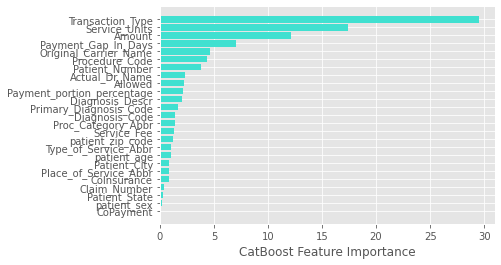

In [1239]:
sorted_feature_importance = cat_model.feature_importances_.argsort()
plt.barh(X_train.columns[sorted_feature_importance], 
        cat_model.feature_importances_[sorted_feature_importance], 
        color='turquoise')
plt.xlabel("CatBoost Feature Importance")

In [1240]:
scalar_num = StandardScaler()

scalar_num.fit(X_train[num_attr_col])
X_train_num = pd.DataFrame(scalar_num.transform(X_train[num_attr_col]), columns=num_attr_col).reset_index(drop=True)
X_test_num = pd.DataFrame(scalar_num.transform(X_test[num_attr_col]), columns=num_attr_col).reset_index(drop=True)

X_train_less_cat = pd.get_dummies(X_train[less_cat_attr_col], prefix_sep="_", drop_first=True).reset_index(drop=True)
X_test_less_cat = pd.get_dummies(X_test[less_cat_attr_col], prefix_sep="_", drop_first=True).reset_index(drop=True)

In [1241]:
# For more cat levels
import category_encoders as ce
cbe_encoder = ce.cat_boost.CatBoostEncoder()
  
# Fit encoder and transform the features
cbe_encoder.fit(X_train[more_cat_attr_col], y_train)
X_train_more_cat = cbe_encoder.transform(X_train[more_cat_attr_col]).reset_index(drop=True)
X_test_more_cat = cbe_encoder.transform(X_test[more_cat_attr_col]).reset_index(drop=True)

X_train_final = pd.concat([X_train_num, X_train_less_cat, X_train_more_cat], axis=1)
X_test_final = pd.concat([X_test_num, X_test_less_cat, X_test_more_cat], axis=1)

In [1242]:
X_train_final.shape

(16691, 29)

In [1243]:
y_train.shape

(16691,)

## Do the Different Model at later part

In [1244]:
# Linear Regression
from sklearn.linear_model import LinearRegression
LR_model = LinearRegression()
LR_model.fit(X_train_final, y_train)
y_train_pred = LR_model.predict(X_train_final)
y_test_pred = LR_model.predict(X_test_final)
model_score(y_train, y_train_pred, y_test, y_test_pred)

Training performance
Mean squared error 0.00
RMSE: 0.04
r2_score is : 0.70
************************
Testing performance
Mean squared error 0.00
RMSE: 0.04
r2_score is : 0.63


In [1245]:
# Decision Tree Regressor

from sklearn.tree import DecisionTreeRegressor 
# create a regressor object
Dt_regressor = DecisionTreeRegressor(max_depth=5,random_state = 123) 
# fit the regressor with X and Y data
Dt_regressor.fit(X_train_final, y_train)
y_train_pred = Dt_regressor.predict(X_train_final)
y_test_pred = Dt_regressor.predict(X_test_final)
model_score(y_train, y_train_pred, y_test, y_test_pred)

Training performance
Mean squared error 0.00
RMSE: 0.03
r2_score is : 0.80
************************
Testing performance
Mean squared error 0.00
RMSE: 0.04
r2_score is : 0.67


In [1246]:
from sklearn.model_selection import GridSearchCV

Dt_regressor = DecisionTreeRegressor() 

parameters={
            "max_depth" : range(1, 20, 1),
           }

DT_Hyperparameter_model=GridSearchCV(Dt_regressor,param_grid=parameters,cv=3)

DT_Hyperparameter_model.fit(X_train_final, y_train)
y_train_pred = DT_Hyperparameter_model.predict(X_train_final)
y_test_pred = DT_Hyperparameter_model.predict(X_test_final)
model_score(y_train, y_train_pred, y_test, y_test_pred)

Training performance
Mean squared error 0.00
RMSE: 0.03
r2_score is : 0.83
************************
Testing performance
Mean squared error 0.00
RMSE: 0.04
r2_score is : 0.68


In [1247]:
# Random forest model
from sklearn.ensemble import RandomForestRegressor
rf_model = RandomForestRegressor()
rf_model.fit(X_train_final, y_train)
y_train_pred = rf_model.predict(X_train_final)
y_test_pred = rf_model.predict(X_test_final)
model_score(y_train, y_train_pred, y_test, y_test_pred)

Training performance
Mean squared error 0.00
RMSE: 0.01
r2_score is : 0.98
************************
Testing performance
Mean squared error 0.00
RMSE: 0.03
r2_score is : 0.78


In [1248]:
# Random forest hyper parameter tuning
rf_model = RandomForestRegressor()

param_grid = {'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [ 2, 4,6, 8,10,12],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800]}

rf_hyper_parm_tuning = GridSearchCV(rf_model,param_grid=parameters,cv=5)
rf_hyper_parm_tuning.fit(X_train_final, y_train)
y_train_pred = rf_hyper_parm_tuning.predict(X_train_final)
y_test_pred = rf_hyper_parm_tuning.predict(X_test_final)
model_score(y_train, y_train_pred, y_test, y_test_pred)

Training performance
Mean squared error 0.00
RMSE: 0.01
r2_score is : 0.97
************************
Testing performance
Mean squared error 0.00
RMSE: 0.03
r2_score is : 0.77


In [1249]:
# Light GBM
import lightgbm as lgb
hyper_params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': ['l1','l2'],
    'learning_rate': 0.08,
    'bagging_freq': 10,
    'verbose': 0,
    "max_depth": 2,
    "num_leaves": 10,  
    "max_bin": 12,
    "num_iterations": 1000
}

gbm = lgb.LGBMRegressor(**hyper_params)

gbm.fit(X_train_final, y_train,
        eval_set=[(X_test_final, y_test)],
        eval_metric='l1',
        early_stopping_rounds=100)

y_train_pred = gbm.predict(X_train_final, num_iteration=gbm.best_iteration_)
y_test_pred = gbm.predict(X_test_final, num_iteration=gbm.best_iteration_)


model_score(y_train, y_train_pred, y_test, y_test_pred)

[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003332 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[1]	valid_0's l1: 0.0365429	valid_0's l2: 0.00355877
Training until validation scores don't improve for 100 rounds
[2]	valid_0's l1: 0.0345502	valid_0's l2: 0.00330346
[3]	valid_0's l1: 0.0326562	valid_0's l2: 0.00305453
[4]	valid_0's l1: 0.0309983	valid_0's l2: 0.00287002
[5]	val

[258]	valid_0's l1: 0.0162404	valid_0's l2: 0.00097935
[259]	valid_0's l1: 0.0162318	valid_0's l2: 0.000978292
[260]	valid_0's l1: 0.0162345	valid_0's l2: 0.000978864
[261]	valid_0's l1: 0.0162338	valid_0's l2: 0.00097867
[262]	valid_0's l1: 0.0162344	valid_0's l2: 0.000978527
[263]	valid_0's l1: 0.0162269	valid_0's l2: 0.000978354
[264]	valid_0's l1: 0.0162293	valid_0's l2: 0.000978516
[265]	valid_0's l1: 0.016227	valid_0's l2: 0.000978451
[266]	valid_0's l1: 0.0162229	valid_0's l2: 0.000978625
[267]	valid_0's l1: 0.0162158	valid_0's l2: 0.000977831
[268]	valid_0's l1: 0.0162075	valid_0's l2: 0.000977686
[269]	valid_0's l1: 0.0161933	valid_0's l2: 0.000977209
[270]	valid_0's l1: 0.0161948	valid_0's l2: 0.00097718
[271]	valid_0's l1: 0.0161915	valid_0's l2: 0.00097717
[272]	valid_0's l1: 0.0161857	valid_0's l2: 0.000976102
[273]	valid_0's l1: 0.0161847	valid_0's l2: 0.000976295
[274]	valid_0's l1: 0.0161862	valid_0's l2: 0.00097588
[275]	valid_0's l1: 0.0161858	valid_0's l2: 0.00097587

[417]	valid_0's l1: 0.0159117	valid_0's l2: 0.000963245
[418]	valid_0's l1: 0.015913	valid_0's l2: 0.000963387
[419]	valid_0's l1: 0.0159149	valid_0's l2: 0.000963426
[420]	valid_0's l1: 0.0159153	valid_0's l2: 0.000963426
[421]	valid_0's l1: 0.0159173	valid_0's l2: 0.000963557
[422]	valid_0's l1: 0.0159131	valid_0's l2: 0.000963187
[423]	valid_0's l1: 0.0159122	valid_0's l2: 0.000963281
[424]	valid_0's l1: 0.015913	valid_0's l2: 0.000963356
[425]	valid_0's l1: 0.0159136	valid_0's l2: 0.000963341
[426]	valid_0's l1: 0.0159066	valid_0's l2: 0.00096293
[427]	valid_0's l1: 0.0158989	valid_0's l2: 0.000962777
[428]	valid_0's l1: 0.0158971	valid_0's l2: 0.000962772
[429]	valid_0's l1: 0.0158953	valid_0's l2: 0.000962435
[430]	valid_0's l1: 0.0158953	valid_0's l2: 0.000962473
[431]	valid_0's l1: 0.0158961	valid_0's l2: 0.000962524
[432]	valid_0's l1: 0.0158954	valid_0's l2: 0.000962548
[433]	valid_0's l1: 0.0158944	valid_0's l2: 0.000962519
[434]	valid_0's l1: 0.0158964	valid_0's l2: 0.00096

[582]	valid_0's l1: 0.015768	valid_0's l2: 0.000950757
[583]	valid_0's l1: 0.015768	valid_0's l2: 0.000950609
[584]	valid_0's l1: 0.0157685	valid_0's l2: 0.000950945
[585]	valid_0's l1: 0.0157667	valid_0's l2: 0.000950934
[586]	valid_0's l1: 0.0157688	valid_0's l2: 0.000951328
[587]	valid_0's l1: 0.0157661	valid_0's l2: 0.000951229
[588]	valid_0's l1: 0.0157653	valid_0's l2: 0.000951195
[589]	valid_0's l1: 0.0157668	valid_0's l2: 0.000951352
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[590]	valid_0's l1: 0.0157673	valid_0's l2: 0.000951476
[591]	valid_0's l1: 0.0157695	valid_0's l2: 0.000951499
[592]	valid_0's l1: 0.0157718	valid_0's l2: 0.00095155
[593]	valid_0's l1: 0.0157704	valid_0's l2: 0.000951476
[594]	valid_0's l1: 0.01577	valid_0's l2: 0.00095148
[595]	valid_0's l1: 0.015773	valid_0's l2: 0.000951783
[596]	valid_0's l1: 0.0157682	valid_0's l2: 0.000951485
[597]	valid_0's l1: 0.0157673	valid_0's l2: 0.000951466
[598]	valid_0's l1: 0.0157683	valid_

[765]	valid_0's l1: 0.0157041	valid_0's l2: 0.000946501
[766]	valid_0's l1: 0.0157027	valid_0's l2: 0.000946625
[767]	valid_0's l1: 0.0157032	valid_0's l2: 0.000946663
[768]	valid_0's l1: 0.015704	valid_0's l2: 0.000946713
[769]	valid_0's l1: 0.0157031	valid_0's l2: 0.000946605
[770]	valid_0's l1: 0.0157033	valid_0's l2: 0.000946532
[771]	valid_0's l1: 0.0157027	valid_0's l2: 0.000946575
[772]	valid_0's l1: 0.0157024	valid_0's l2: 0.000946124
[773]	valid_0's l1: 0.0157017	valid_0's l2: 0.000945974
[774]	valid_0's l1: 0.0157022	valid_0's l2: 0.000946003
[775]	valid_0's l1: 0.0157026	valid_0's l2: 0.00094597
[776]	valid_0's l1: 0.0157023	valid_0's l2: 0.000946243
[777]	valid_0's l1: 0.0157018	valid_0's l2: 0.000946133
[778]	valid_0's l1: 0.0157024	valid_0's l2: 0.000946629
[779]	valid_0's l1: 0.015702	valid_0's l2: 0.000946525
[780]	valid_0's l1: 0.0157014	valid_0's l2: 0.000946586
[781]	valid_0's l1: 0.0157025	valid_0's l2: 0.000946518
[782]	valid_0's l1: 0.0157024	valid_0's l2: 0.00094

[952]	valid_0's l1: 0.01565	valid_0's l2: 0.000942439
[953]	valid_0's l1: 0.015648	valid_0's l2: 0.000941944
[954]	valid_0's l1: 0.0156477	valid_0's l2: 0.000941799
[955]	valid_0's l1: 0.0156496	valid_0's l2: 0.000941732
[956]	valid_0's l1: 0.0156489	valid_0's l2: 0.000941807
[957]	valid_0's l1: 0.015648	valid_0's l2: 0.000941811
[958]	valid_0's l1: 0.015648	valid_0's l2: 0.000942122
[959]	valid_0's l1: 0.0156464	valid_0's l2: 0.000941959
[960]	valid_0's l1: 0.0156446	valid_0's l2: 0.000941595
[961]	valid_0's l1: 0.0156452	valid_0's l2: 0.000941973
[962]	valid_0's l1: 0.0156448	valid_0's l2: 0.00094199
[963]	valid_0's l1: 0.0156447	valid_0's l2: 0.000942169
[964]	valid_0's l1: 0.0156444	valid_0's l2: 0.000942168
[965]	valid_0's l1: 0.0156445	valid_0's l2: 0.000942124
[966]	valid_0's l1: 0.0156418	valid_0's l2: 0.000941791
[967]	valid_0's l1: 0.0156385	valid_0's l2: 0.000941749
[968]	valid_0's l1: 0.0156398	valid_0's l2: 0.000941879
[969]	valid_0's l1: 0.0156396	valid_0's l2: 0.00094187

In [1250]:
from xgboost import XGBRegressor
xgb_model = XGBRegressor()
xgb_model.fit(X_train_final, y_train)

y_train_pred = xgb_model.predict(X_train_final)
y_test_pred = xgb_model.predict(X_test_final)
model_score(y_train, y_train_pred, y_test, y_test_pred)

Training performance
Mean squared error 0.00
RMSE: 0.01
r2_score is : 0.97
************************
Testing performance
Mean squared error 0.00
RMSE: 0.03
r2_score is : 0.78
